Amanda Knudsen
DATA-602 Final Project
May 2025

1. Research Question

*Where in the greater Boston area are the best elementary school districts?* The goal of this project would be to use data science techniques to explore whether there are any measurable relationships between various school district factors, such as class size, expenditures, and student performance outcomes (e.g., reading and math scores), among other value factors, with a special interest in elementary schools. Some initial guiding questions I am interested in are whether larger expenditures correlate with better student performance, and whether school districts that spend more per student achieve better outcomes in one subject area versus another. The thought of buying a home is a major life decision and we want to narrow our search and inform our decision using as much available information as possible. We'll want to find a home and a place we can live in for years to come knowing that there are strong educational opportunities at the local public schools.

2. Justification - why is this relevant to you or industry?

The motivation for this project stems from personal interest: my husband and I are expecting a baby girl in August 2025, our first child, and we are interested in eventually moving to my home state of Massachusetts to be closer to family. We've lived in NYC for 15 years and searching for a place to live out-of-state is a challenge. *When we look for places to buy a house, which towns should we consider, and how can we compare them?* When we look at homes through websites like Zillow and Redfin, information about the associated public school districts is limited to an overall rating of the school based on a blend of unknown factors alongside a 'rating' from what appears to be a typically small group of self-selected parents from an unknown period of time. This information is not only unreliable and biased, but it also is provided on a house-by-house basis, which is not useful for our personal goals of identifying areas to target, not yet specific homes. We are interested in identifying places to look for houses that have good elementary school districts that offer strong educational outcomes, and comparing the data points about what makes a school district a good option for us.

4. Data Sources 
   
All are publicly available data from the Massachusetts Department of Education.

- [Per Pupil Expenditures: 2023 (Max Year) Selected](https://profiles.doe.mass.edu/statereport/ppx.aspx)
- [MCAS Achievement Results 2024 - Grades 3, 4, and 5 and total Grade 3-8](https://profiles.doe.mass.edu/statereport/mcas.aspx)
- [Reference: MCAS Achievement Results Data Dictionary](https://profiles.doe.mass.edu/help/data.aspx?section=assess)


6. Libraries being used.

   - pandas
   - numpy
   - seaborn
   - scikit-learn

## Data Collection and Data Cleansing 
First we brought in two of the datasets, the MCAS (Massachusetts Comprehensive Assessment System) Achievement Results 2024 for grades 3-8 and the expenditures per district. We had to do a bit of cleaning first to get the dataframes into a format that could be merged, including pivoting the MCAS dataset so that we could look at the percentage of "Exceeding Expectations and Exceeding Expectations" (acronym ME), "Partially Meeting Expectations" (acronym PM), and "Not Meeting Expectations" (acronym NM). Then after pivoting that dataset so we could see those percentages per subject matter (English Language Arts, Math, and Science) per district, rather than a separate row for each subject-district pair, we were able to left join the expenditures dataset using the District Code found in both.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [2]:
# Display all columns
pd.set_option('display.max_columns', None)

Below we load per pupil expenditure data, which provides essential context for evaluating how district spending relates to student outcomes.

In [6]:
df_exp = pd.read_excel('ProjectData/PerPupilExpenditures_2023.xlsx', header=1)
df_exp

District Name  District Code  \
0         Abby Kelley Foster Charter Public (District)        4450000   
1                                             Abington          10000   
2    Academy Of the Pacific Rim Charter Public (Dis...        4120000   
3                                     Acton-Boxborough        6000000   
4                                             Acushnet          30000   
..                                                 ...            ...   
393                                             Woburn        3470000   
394                                          Worcester        3480000   
395                                        Worthington        3490000   
396                                           Wrentham        3500000   
397                                       State Totals              0   

     In-District Expenditures Total In-district FTEs  \
0              $24,231,438.78                1,415.8   
1              $35,603,421.16                2,143.5   
2              $12,801,946.92                  467.4   
3             $100,564,755.40                5,181.7   
4              $14,679,700.00                  965.8   
..                        ...                    ...   
393            $94,093,579.73                4,289.4   
394           $501,140,676.40               24,319.6   
395             $1,904,264.00                   75.5   
396            $17,626,509.66                  920.9   
397        $18,401,964,825.00              865,749.1   

    In-District Expenditures per Pupil        Total Expenditures  \
0                           $17,114.65            $24,231,438.78   
1                           $16,609.95            $41,098,932.87   
2                           $27,392.63            $12,801,946.92   
3                           $19,407.68           $109,746,603.20   
4                           $15,199.52            $18,752,410.80   
..                                 ...                       ...   
393                         $21,936.30           $105,328,116.50   
394                         $20,606.45           $568,546,854.00   
395                         $25,222.04             $2,822,565.38   
396                         $19,140.53            $19,059,388.49   
397                         $21,255.54        $20,737,958,663.00   

       Total Pupil FTEs Total Expenditures per Pupil  
0               1,415.8                   $17,114.65  
1               2,297.3                   $17,890.10  
2                 467.4                   $27,392.63  
3               5,302.1                   $20,698.70  
4               1,254.7                   $14,945.73  
..                  ...                          ...  
393             4,516.7                   $23,319.71  
394            27,234.8                   $20,875.75  
395               142.1                   $19,863.23  
396               981.1                   $19,426.55  
397           947,578.4                   $21,885.22  

[398 rows x 8 columns]

Below we import MCAS results for grades 3–8, which include both categorical proficiency levels (e.g., Meets or Exceeds Expectations) and average scaled scores by subject and district.

In [9]:
df_exp = df_exp.rename(columns={
    "District Code": "district_code",
    "In-District Expenditures per Pupil": "per_pupil_expenditure",
    "Total Expenditures per Pupil": "total_expenditure_per_pupil",
    "In-District Expenditures": "indistrict_expenditures",
    "Total In-district FTEs": "total_indistrict_ftes",
    "Total Expenditures": "total_expenditures",
    "Total Pupil FTEs": "total_pupil_ftes"
    
})

df_exp.columns

Index(['District Name', 'district_code', 'indistrict_expenditures',
       'total_indistrict_ftes', 'per_pupil_expenditure', 'total_expenditures',
       'total_pupil_ftes', 'total_expenditure_per_pupil'],
      dtype='object')

In [11]:
df_exp = df_exp[['district_code', 'indistrict_expenditures',
       'total_indistrict_ftes', 'per_pupil_expenditure', 'total_expenditures',
       'total_pupil_ftes', 'total_expenditure_per_pupil']]

Now we will bring in the MCAS data for grades 3-8.

In [14]:
df_mcas = pd.read_excel('ProjectData/NextGenMCAS_2024Grade3-8.xlsx', header=1)
df_mcas

District Name  District Code Subject  \
0     Abby Kelley Foster Charter Public (District)        4450000     ELA   
1     Abby Kelley Foster Charter Public (District)        4450000    MATH   
2     Abby Kelley Foster Charter Public (District)        4450000     SCI   
3                                         Abington          10000     ELA   
4                                         Abington          10000    MATH   
...                                            ...            ...     ...   
1052                                      Wrentham        3500000    MATH   
1053                                      Wrentham        3500000     SCI   
1054                                         State              0     ELA   
1055                                         State              0    MATH   
1056                                         State              0     SCI   

             M+E #  M+E %           E #  E %           M #  M %          PM #  \
0              231     32            21    3           210   29           371   
1              221     31            20    3           201   28           380   
2               81     36             6    3            75   33           111   
3              412     42            65    7           347   35           409   
4              411     42            57    6           354   36           445   
...            ...    ...           ...  ...           ...  ...           ...   
1052           303     61            66   13           237   48           163   
1053            74     65            19   17            55   48            37   
1054       154,579     39        29,433    7       125,146   32       158,752   
1055       161,477     41        30,091    8       131,386   33       163,974   
1056        55,749     42         8,540    6        47,209   36        50,637   

      PM %          NM #  NM % No. of Students Included  Part. Rate %  \
0       52           118    16                      720           100   
1       53           119    17                      720           100   
2       49            36    16                      228           100   
3       41           166    17                      987            98   
4       45           132    13                      988            98   
...    ...           ...   ...                      ...           ...   
1052    33            27     5                      493           100   
1053    32             3     3                      114           100   
1054    40        81,334    21                  394,665            99   
1055    42        69,303    18                  394,754            99   
1056    38        26,507    20                  132,893            99   

      Avg. Scaled Score   SGP Included In SGP  
0                   490  52.0             581  
1                   490  54.0             581  
2                   492   NaN             NaN  
3                   495  49.0             750  
4                   496  47.0             752  
...                 ...   ...             ...  
1052                506  52.0             356  
1053                510   NaN             NaN  
1054                493  50.0         312,097  
1055                495  50.0         313,518  
1056                494   NaN             NaN  

[1057 rows x 18 columns]

We'll rename the columns to exclude punctuation and spaces for the same reasons that we removed them in the prior dataset. 

In [17]:
df_mcas = df_mcas.rename(columns={
    "District Name": "district_name",
    "District Code": "district_code",
    "Subject": "subject",
    "M+E %": "me_pct",
    "E %": "e_pct",
    "M %": "m_pct",
    "PM %": "pm_pct",
    "NM %": "nm_pct",
    "Part. Rate %": "participation_pct",
    "No. of Students Included": "num_students_included",
    "Avg. Scaled Score": "avg_scaled_score"
})

In [19]:
df_mcas.head()

district_name  district_code subject  \
0  Abby Kelley Foster Charter Public (District)        4450000     ELA   
1  Abby Kelley Foster Charter Public (District)        4450000    MATH   
2  Abby Kelley Foster Charter Public (District)        4450000     SCI   
3                                      Abington          10000     ELA   
4                                      Abington          10000    MATH   

          M+E #  me_pct           E #  e_pct           M #  m_pct  \
0           231      32            21      3           210     29   
1           221      31            20      3           201     28   
2            81      36             6      3            75     33   
3           412      42            65      7           347     35   
4           411      42            57      6           354     36   

           PM #  pm_pct          NM #  nm_pct num_students_included  \
0           371      52           118      16                   720   
1           380      53           119      17                   720   
2           111      49            36      16                   228   
3           409      41           166      17                   987   
4           445      45           132      13                   988   

   participation_pct  avg_scaled_score   SGP Included In SGP  
0                100               490  52.0             581  
1                100               490  54.0             581  
2                100               492   NaN             NaN  
3                 98               495  49.0             750  
4                 98               496  47.0             752

In [21]:
df_mcas = df_mcas[["district_name","district_code","subject","me_pct","pm_pct","nm_pct","participation_pct", "num_students_included", "avg_scaled_score"]]

In [23]:
# pivoting so that we have the scores for math, english-language-arts (ELA) and science in separate columns
df_mcas_pivoted = df_mcas.pivot(index=["district_name", "district_code"], 
                                columns="subject", values=["me_pct", "pm_pct", "nm_pct", "participation_pct", "avg_scaled_score"])

In [25]:
df_mcas_pivoted.columns = ['_'.join(col) if isinstance(col, tuple) else col for col in df_mcas_pivoted.columns]

In [27]:
df_mcas_pivoted = df_mcas_pivoted.reset_index()

In [29]:
df_mcas_pivoted

district_name  district_code  \
0         Abby Kelley Foster Charter Public (District)        4450000   
1                                             Abington          10000   
2    Academy Of the Pacific Rim Charter Public (Dis...        4120000   
3                                     Acton-Boxborough        6000000   
4                                             Acushnet          30000   
..                                                 ...            ...   
350                                             Woburn        3470000   
351                                          Worcester        3480000   
352  Worcester Cultural Academy Charter Public Scho...       35190000   
353                                        Worthington        3490000   
354                                           Wrentham        3500000   

     me_pct_ELA  me_pct_MATH  me_pct_SCI  pm_pct_ELA  pm_pct_MATH  pm_pct_SCI  \
0          32.0         31.0        36.0        52.0         53.0        49.0   
1          42.0         42.0        50.0        41.0         45.0        37.0   
2          14.0          8.0        13.0        47.0         55.0        46.0   
3          64.0         69.0        72.0        29.0         25.0        21.0   
4          51.0         53.0        46.0        41.0         40.0        44.0   
..          ...          ...         ...         ...          ...         ...   
350        35.0         34.0        40.0        44.0         47.0        41.0   
351        23.0         23.0        21.0        42.0         47.0        44.0   
352        13.0          3.0         NaN        48.0         43.0         NaN   
353        28.0         32.0         NaN        60.0         49.0         NaN   
354        57.0         61.0        65.0        35.0         33.0        32.0   

     nm_pct_ELA  nm_pct_MATH  nm_pct_SCI  participation_pct_ELA  \
0          16.0         17.0        16.0                  100.0   
1          17.0         13.0        13.0                   98.0   
2          39.0         37.0        41.0                   99.0   
3           7.0          6.0         6.0                   99.0   
4           9.0          7.0        10.0                  100.0   
..          ...          ...         ...                    ...   
350        22.0         18.0        19.0                   99.0   
351        35.0         30.0        35.0                   99.0   
352        40.0         55.0         NaN                  100.0   
353        13.0         20.0         NaN                   98.0   
354         8.0          5.0         3.0                   99.0   

     participation_pct_MATH  participation_pct_SCI  avg_scaled_score_ELA  \
0                     100.0                  100.0                 490.0   
1                      98.0                   99.0                 495.0   
2                      99.0                   99.0                 477.0   
3                      99.0                   99.0                 508.0   
4                     100.0                  100.0                 501.0   
..                      ...                    ...                   ...   
350                    99.0                   99.0                 490.0   
351                    99.0                   99.0                 482.0   
352                   100.0                    NaN                 475.0   
353                   100.0                    NaN                 489.0   
354                   100.0                  100.0                 504.0   

     avg_scaled_score_MATH  avg_scaled_score_SCI  
0                    490.0                 492.0  
1                    496.0                 499.0  
2                    477.0                 477.0  
3                    511.0                 511.0  
4                    502.0                 498.0  
..                     ...                   ...  
350                  491.0                 494.0  
351                  484.0                 481.0  
352           

In [31]:
df_merged = df_mcas_pivoted.merge(df_exp, on="district_code", how="left")
df_merged

district_name  district_code  \
0         Abby Kelley Foster Charter Public (District)        4450000   
1                                             Abington          10000   
2    Academy Of the Pacific Rim Charter Public (Dis...        4120000   
3                                     Acton-Boxborough        6000000   
4                                             Acushnet          30000   
..                                                 ...            ...   
350                                             Woburn        3470000   
351                                          Worcester        3480000   
352  Worcester Cultural Academy Charter Public Scho...       35190000   
353                                        Worthington        3490000   
354                                           Wrentham        3500000   

     me_pct_ELA  me_pct_MATH  me_pct_SCI  pm_pct_ELA  pm_pct_MATH  pm_pct_SCI  \
0          32.0         31.0        36.0        52.0         53.0        49.0   
1          42.0         42.0        50.0        41.0         45.0        37.0   
2          14.0          8.0        13.0        47.0         55.0        46.0   
3          64.0         69.0        72.0        29.0         25.0        21.0   
4          51.0         53.0        46.0        41.0         40.0        44.0   
..          ...          ...         ...         ...          ...         ...   
350        35.0         34.0        40.0        44.0         47.0        41.0   
351        23.0         23.0        21.0        42.0         47.0        44.0   
352        13.0          3.0         NaN        48.0         43.0         NaN   
353        28.0         32.0         NaN        60.0         49.0         NaN   
354        57.0         61.0        65.0        35.0         33.0        32.0   

     nm_pct_ELA  nm_pct_MATH  nm_pct_SCI  participation_pct_ELA  \
0          16.0         17.0        16.0                  100.0   
1          17.0         13.0        13.0                   98.0   
2          39.0         37.0        41.0                   99.0   
3           7.0          6.0         6.0                   99.0   
4           9.0          7.0        10.0                  100.0   
..          ...          ...         ...                    ...   
350        22.0         18.0        19.0                   99.0   
351        35.0         30.0        35.0                   99.0   
352        40.0         55.0         NaN                  100.0   
353        13.0         20.0         NaN                   98.0   
354         8.0          5.0         3.0                   99.0   

     participation_pct_MATH  participation_pct_SCI  avg_scaled_score_ELA  \
0                     100.0                  100.0                 490.0   
1                      98.0                   99.0                 495.0   
2                      99.0                   99.0                 477.0   
3                      99.0                   99.0                 508.0   
4                     100.0                  100.0                 501.0   
..                      ...                    ...                   ...   
350                    99.0                   99.0                 490.0   
351                    99.0                   99.0                 482.0   
352                   100.0                    NaN                 475.0   
353                   100.0                    NaN                 489.0   
354                   100.0                  100.0                 504.0   

     avg_scaled_score_MATH  avg_scaled_score_SCI   indistrict_expenditures  \
0                    490.0                 492.0            $24,231,438.78   
1                    496.0                 499.0            $35,603,421.16   
2                    477.0                 477.0            $12,801,946.92   
3                    511.0                 511.0           $100,564,755.40   
4                    502.0                 498.0            $14,679,700.00   
..   

In [33]:
df_merged.describe()

district_code  me_pct_ELA  me_pct_MATH  me_pct_SCI  pm_pct_ELA  \
count   3.550000e+02  355.000000   355.000000  347.000000  355.000000   
mean    4.235465e+06   40.363380    41.512676   45.138329   42.256338   
std     6.494659e+06   15.183075    17.484028   17.461714    8.051682   
min     0.000000e+00    6.000000     3.000000    5.000000   18.000000   
25%     1.445000e+06   28.000000    29.000000   33.000000   37.000000   
50%     2.720000e+06   40.000000    41.000000   44.000000   43.000000   
75%     4.635000e+06   52.000000    55.000000   58.000000   48.000000   
max     3.902000e+07   79.000000    82.000000   95.000000   66.000000   

       pm_pct_MATH  pm_pct_SCI  nm_pct_ELA  nm_pct_MATH  nm_pct_SCI  \
count   355.000000  347.000000  355.000000   355.000000  347.000000   
mean     43.628169   38.893372   17.416901    14.830986   16.002882   
std      10.290816    9.903152    9.851482     9.631613   10.580683   
min      16.000000    0.000000    2.000000     0.000000    0.000000   
25%      37.000000   33.000000   10.000000     7.000000    8.000000   
50%      45.000000   40.000000   15.000000    13.000000   14.000000   
75%      51.000000   45.000000   23.000000    20.000000   21.000000   
max      83.000000   69.000000   55.000000    56.000000   59.000000   

       participation_pct_ELA  participation_pct_MATH  participation_pct_SCI  \
count             355.000000              355.000000             347.000000   
mean               98.825352               98.901408              98.446686   
std                 1.968087                2.031913               2.136771   
min                75.000000               75.000000              80.000000   
25%                99.000000               99.000000              98.000000   
50%                99.000000               99.000000              99.000000   
75%               100.000000              100.000000             100.000000   
max               100.000000              100.000000             100.000000   

       avg_scaled_score_ELA  avg_scaled_score_MATH  avg_scaled_score_SCI  
count            355.000000             355.000000            347.000000  
mean             494.284507             495.456338            495.847262  
std                9.040753               9.786430              9.877707  
min              470.000000             467.000000            469.000000  
25%              488.000000             489.000000            489.000000  
50%              495.000000             495.000000            496.000000  
75%              501.000000             503.000000            503.000000  
max              516.000000             520.000000            517.000000

In [35]:
# since it looks like the expenditures data is still in strings, we'll convert to numeric and remove non-numeric characters like $
expenditure_cols = ["indistrict_expenditures", "total_indistrict_ftes", "per_pupil_expenditure",
                    "total_expenditures", "total_pupil_ftes", "total_expenditure_per_pupil"]

for col in expenditure_cols:
    df_merged[col] = df_merged[col].astype(str).str.replace(r"[^0-9.]", "", regex=True)  # Remove $ and ,
    df_merged[col] = pd.to_numeric(df_merged[col], errors="coerce")  # Convert to float

In [37]:
df_merged

district_name  district_code  \
0         Abby Kelley Foster Charter Public (District)        4450000   
1                                             Abington          10000   
2    Academy Of the Pacific Rim Charter Public (Dis...        4120000   
3                                     Acton-Boxborough        6000000   
4                                             Acushnet          30000   
..                                                 ...            ...   
350                                             Woburn        3470000   
351                                          Worcester        3480000   
352  Worcester Cultural Academy Charter Public Scho...       35190000   
353                                        Worthington        3490000   
354                                           Wrentham        3500000   

     me_pct_ELA  me_pct_MATH  me_pct_SCI  pm_pct_ELA  pm_pct_MATH  pm_pct_SCI  \
0          32.0         31.0        36.0        52.0         53.0        49.0   
1          42.0         42.0        50.0        41.0         45.0        37.0   
2          14.0          8.0        13.0        47.0         55.0        46.0   
3          64.0         69.0        72.0        29.0         25.0        21.0   
4          51.0         53.0        46.0        41.0         40.0        44.0   
..          ...          ...         ...         ...          ...         ...   
350        35.0         34.0        40.0        44.0         47.0        41.0   
351        23.0         23.0        21.0        42.0         47.0        44.0   
352        13.0          3.0         NaN        48.0         43.0         NaN   
353        28.0         32.0         NaN        60.0         49.0         NaN   
354        57.0         61.0        65.0        35.0         33.0        32.0   

     nm_pct_ELA  nm_pct_MATH  nm_pct_SCI  participation_pct_ELA  \
0          16.0         17.0        16.0                  100.0   
1          17.0         13.0        13.0                   98.0   
2          39.0         37.0        41.0                   99.0   
3           7.0          6.0         6.0                   99.0   
4           9.0          7.0        10.0                  100.0   
..          ...          ...         ...                    ...   
350        22.0         18.0        19.0                   99.0   
351        35.0         30.0        35.0                   99.0   
352        40.0         55.0         NaN                  100.0   
353        13.0         20.0         NaN                   98.0   
354         8.0          5.0         3.0                   99.0   

     participation_pct_MATH  participation_pct_SCI  avg_scaled_score_ELA  \
0                     100.0                  100.0                 490.0   
1                      98.0                   99.0                 495.0   
2                      99.0                   99.0                 477.0   
3                      99.0                   99.0                 508.0   
4                     100.0                  100.0                 501.0   
..                      ...                    ...                   ...   
350                    99.0                   99.0                 490.0   
351                    99.0                   99.0                 482.0   
352                   100.0                    NaN                 475.0   
353                   100.0                    NaN                 489.0   
354                   100.0                  100.0                 504.0   

     avg_scaled_score_MATH  avg_scaled_score_SCI  indistrict_expenditures  \
0                    490.0                 492.0             2.423144e+07   
1                    496.0                 499.0             3.560342e+07   
2                    477.0                 477.0             1.280195e+07   
3                    511.0                 511.0             1.005648e+08   
4                    502.0                 498.0             1.467970e+07   
..         

In [39]:
# Show count of missing values in each column, sorted in descending order
missing_summary = df_merged.isna().sum().sort_values(ascending=False)
missing_summary[missing_summary > 0]

me_pct_SCI                     8
nm_pct_SCI                     8
pm_pct_SCI                     8
avg_scaled_score_SCI           8
participation_pct_SCI          8
total_indistrict_ftes          2
per_pupil_expenditure          2
total_expenditure_per_pupil    2
total_expenditures             2
indistrict_expenditures        2
total_pupil_ftes               2
dtype: int64

Since there are relatively few instances of missing data, and it appears that the missingness occurs across multiple columns for the same rows (based on a visual inspection of the data above), let's remove the rows where there are any missing values.

In [42]:
df_clean = df_merged.dropna().copy()

In [44]:
df_clean 

district_name  district_code  \
0         Abby Kelley Foster Charter Public (District)        4450000   
1                                             Abington          10000   
2    Academy Of the Pacific Rim Charter Public (Dis...        4120000   
3                                     Acton-Boxborough        6000000   
4                                             Acushnet          30000   
..                                                 ...            ...   
348                                         Winchester        3440000   
349                                           Winthrop        3460000   
350                                             Woburn        3470000   
351                                          Worcester        3480000   
354                                           Wrentham        3500000   

     me_pct_ELA  me_pct_MATH  me_pct_SCI  pm_pct_ELA  pm_pct_MATH  pm_pct_SCI  \
0          32.0         31.0        36.0        52.0         53.0        49.0   
1          42.0         42.0        50.0        41.0         45.0        37.0   
2          14.0          8.0        13.0        47.0         55.0        46.0   
3          64.0         69.0        72.0        29.0         25.0        21.0   
4          51.0         53.0        46.0        41.0         40.0        44.0   
..          ...          ...         ...         ...          ...         ...   
348        66.0         74.0        80.0        29.0         23.0        17.0   
349        43.0         42.0        43.0        41.0         44.0        43.0   
350        35.0         34.0        40.0        44.0         47.0        41.0   
351        23.0         23.0        21.0        42.0         47.0        44.0   
354        57.0         61.0        65.0        35.0         33.0        32.0   

     nm_pct_ELA  nm_pct_MATH  nm_pct_SCI  participation_pct_ELA  \
0          16.0         17.0        16.0                  100.0   
1          17.0         13.0        13.0                   98.0   
2          39.0         37.0        41.0                   99.0   
3           7.0          6.0         6.0                   99.0   
4           9.0          7.0        10.0                  100.0   
..          ...          ...         ...                    ...   
348         5.0          4.0         3.0                   99.0   
349        16.0         14.0        15.0                   99.0   
350        22.0         18.0        19.0                   99.0   
351        35.0         30.0        35.0                   99.0   
354         8.0          5.0         3.0                   99.0   

     participation_pct_MATH  participation_pct_SCI  avg_scaled_score_ELA  \
0                     100.0                  100.0                 490.0   
1                      98.0                   99.0                 495.0   
2                      99.0                   99.0                 477.0   
3                      99.0                   99.0                 508.0   
4                     100.0                  100.0                 501.0   
..                      ...                    ...                   ...   
348                   100.0                   99.0                 509.0   
349                    99.0                   99.0                 496.0   
350                    99.0                   99.0                 490.0   
351                    99.0                   99.0                 482.0   
354                   100.0                  100.0                 504.0   

     avg_scaled_score_MATH  avg_scaled_score_SCI  indistrict_expenditures  \
0                    490.0                 492.0             2.423144e+07   
1                    496.0                 499.0             3.560342e+07   
2                    477.0                 477.0             1.280195e+07   
3                    511.0                 511.0             1.005648e+08   
4                    502.0                 498.0             1.467970e+07   
..         

We still have 347 rows after dropping those with any `NA` values, so this means our drop of na values was logical for our purposes. After all, we can't reasonably consider moving to every single district in the entire state of Massachusetts!

## EDA

When we examine the histograms and especially the boxplots below: Interestingly, there is the broadest distribution for percentage in meeting or exceeding expectations for the science component of MCAS, with a range from apparently near 10% to nearly 90%, without outliers. There are outliers for each of the partially meets expectations on both ends of the spectrum for all subjects, and far more outliers in the not meeting expectations for all subjects in the ranges above 35%.

In our correlation heatmap we can see that districts with a high percentage of "me" or Meets Expectations and Exceeds Expectations for one subject matter tend to also have a high percentage of "me" for other subject matters. (For example, a district that has a high "me" percentage for English Language Arts (ELA) tends to have a high "me" percentage for Math and Science.)

<Figure size 1200x600 with 0 Axes>

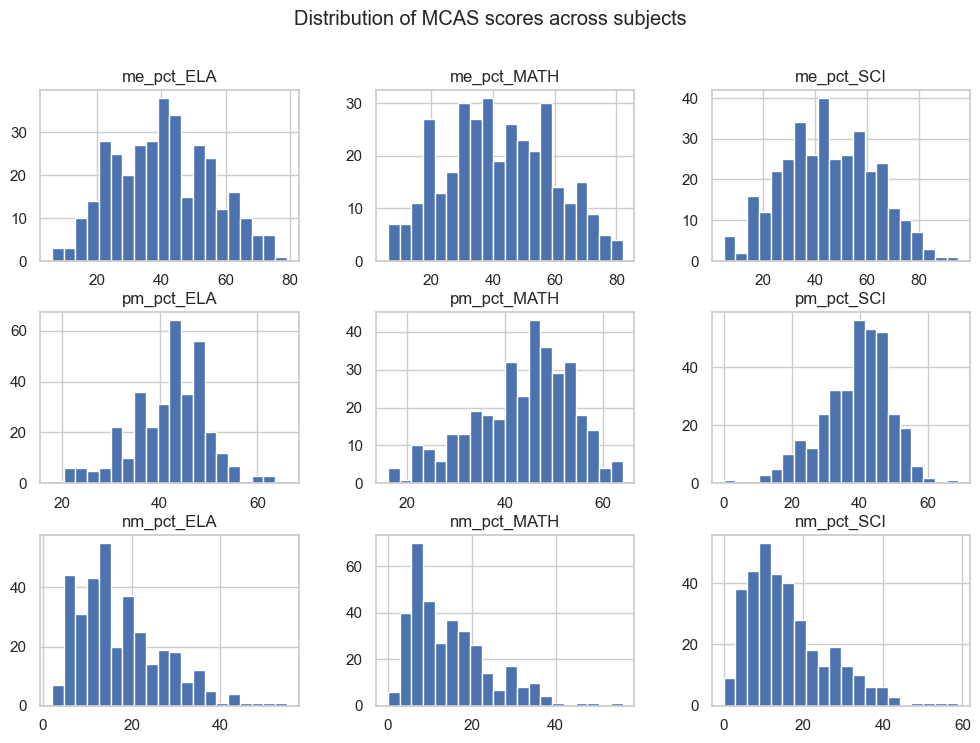

In [49]:
# Histograms for MCAS performance
plt.figure(figsize=(12,6))
df_clean.iloc[:, 2:11].hist(figsize=(12,8), bins=20)
plt.suptitle("Distribution of MCAS scores across subjects")
plt.show()

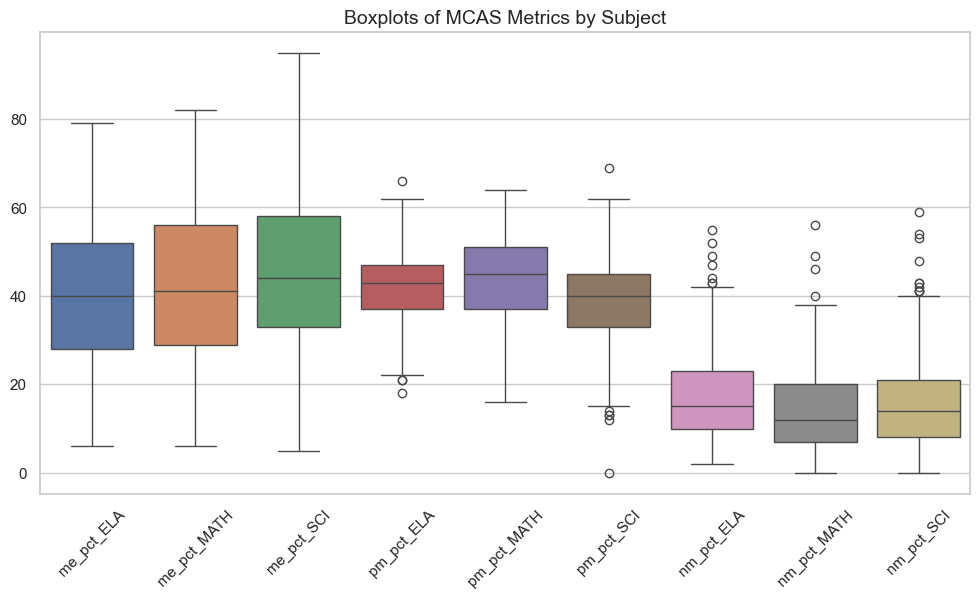

In [51]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_clean.iloc[:, 2:11])
plt.xticks(rotation=45)
plt.title("Boxplots of MCAS Metrics by Subject", fontsize=14)
plt.show()

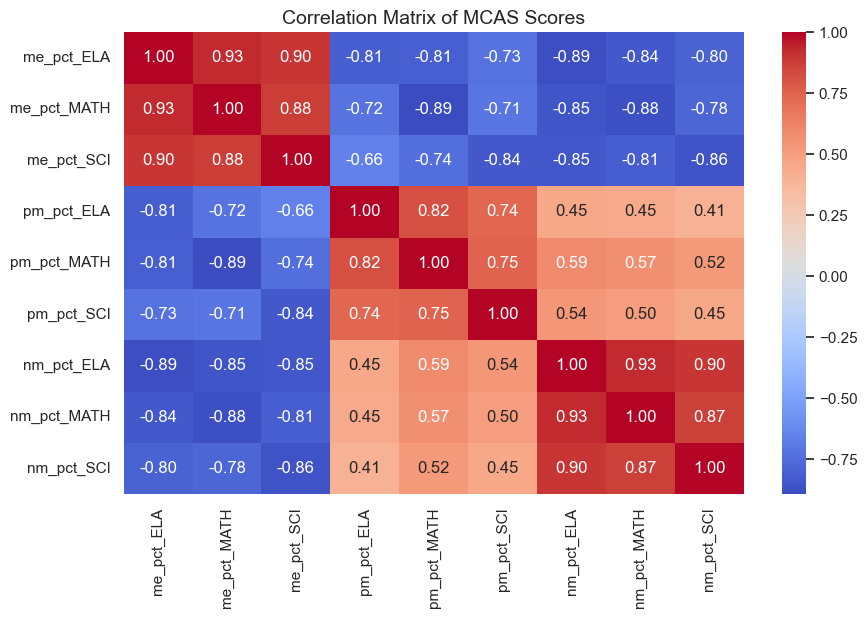

In [53]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_clean.iloc[:, 2:11].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of MCAS Scores", fontsize=14)
plt.show()

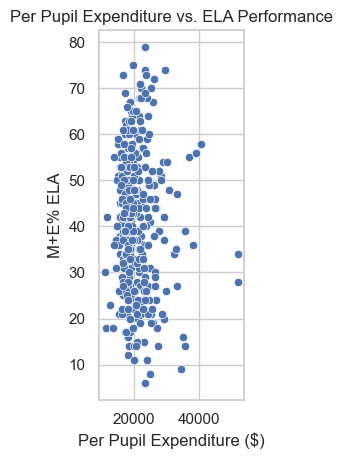

In [55]:
# ELA
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_clean, x="per_pupil_expenditure", y="me_pct_ELA")
plt.title("Per Pupil Expenditure vs. ELA Performance")
plt.xlabel("Per Pupil Expenditure ($)")
plt.ylabel("M+E% ELA")

plt.show()

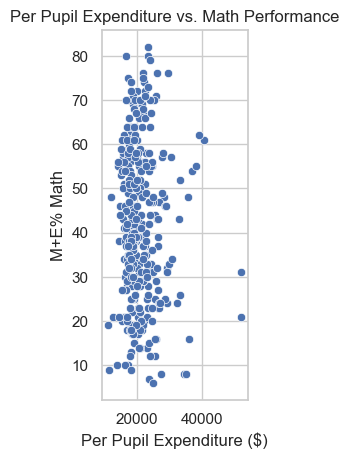

In [57]:
# Math
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_clean, x="per_pupil_expenditure", y="me_pct_MATH")
plt.title("Per Pupil Expenditure vs. Math Performance")
plt.xlabel("Per Pupil Expenditure ($)")
plt.ylabel("M+E% Math")
plt.show()


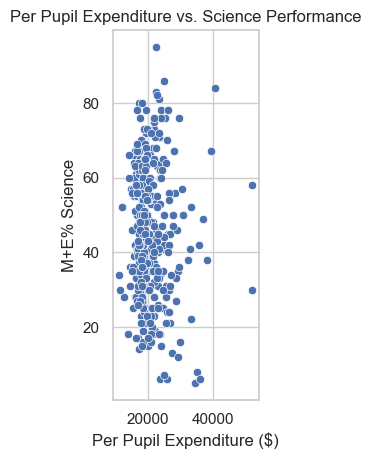

In [59]:
# Science
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_clean, x="per_pupil_expenditure", y="me_pct_SCI")
plt.title("Per Pupil Expenditure vs. Science Performance")
plt.xlabel("Per Pupil Expenditure ($)")
plt.ylabel("M+E% Science")
plt.show()

## Creating Derived Variables

We engineer new features like average % Meets Expectations across subjects to support comparative analysis.

In [62]:
# Identify Top & Bottom Performing Districts (Based on Average M+E% Across Subjects)
df_clean["average_me_pct"] = df_clean[["me_pct_ELA", "me_pct_MATH", "me_pct_SCI"]].mean(axis=1)

In [64]:
# Top 20 Performing Districts
top_districts = df_clean.nlargest(20, "average_me_pct")[["district_name", "average_me_pct", "per_pupil_expenditure"]]
top_districts

district_name  average_me_pct  \
57                                      Carlisle       78.333333   
28   Benjamin Banneker Charter Public (District)       77.333333   
146                                    Hopkinton       77.000000   
163                                    Lexington       76.000000   
345                                 Williamsburg       75.666667   
330                                    Wellesley       75.333333   
339                                       Weston       75.333333   
27                                       Belmont       74.666667   
328                                      Wayland       74.000000   
138                                      Hingham       73.333333   
348                                   Winchester       73.333333   
131                                      Harvard       73.000000   
72                                       Concord       72.000000   
83                                Dover-Sherborn       72.000000   
288                                 Southborough       71.666667   
82                                         Dover       71.333333   
341                                     Westwood       71.333333   
13                                     Arlington       69.666667   
48                                     Brimfield       69.666667   
52                                     Brookline       69.333333   

     per_pupil_expenditure  
57                23445.84  
28                23329.17  
146               16570.76  
163               23842.32  
345               22402.27  
330               26197.39  
339               29581.26  
27                17253.27  
328               21734.66  
138               19849.94  
348               18002.28  
131               22377.37  
72                25216.63  
83                23968.78  
288               22053.02  
82                21822.31  
341               23306.67  
13                18799.25  
48                17513.79  
52                25748.76

In [66]:
# Bottom 20 Performing Districts
bottom_districts = df_clean.nsmallest(20, "average_me_pct")[["district_name", "average_me_pct", "per_pupil_expenditure"]]
bottom_districts

district_name  average_me_pct  \
23   Baystate Academy Charter Public School (District)        6.333333   
142                                            Holyoke        7.000000   
67            Codman Academy Charter Public (District)        7.333333   
135  Helen Y. Davis Leadership Academy Charter Publ...       10.666667   
2    Academy Of the Pacific Rim Charter Public (Dis...       11.666667   
183  Martin Luther King, Jr. Charter School of Exce...       12.000000   
314     UP Academy Charter School of Boston (District)       12.000000   
289                                        Southbridge       12.666667   
39   Boston Green Academy Horace Mann Charter Schoo...       13.666667   
115          Global Learning Charter Public (District)       13.666667   
215  New Heights Charter School of Brockton (District)       15.333333   
294       Springfield International Charter (District)       15.333333   
61                                             Chelsea       16.000000   
155                                           Lawrence       16.333333   
12         Argosy Collegiate Charter School (District)       16.666667   
157    Learning First Charter Public School (District)       16.666667   
315  UP Academy Charter School of Dorchester (Distr...       16.666667   
95                                             Everett       17.333333   
172                                               Lynn       17.333333   
151      KIPP Academy Boston Charter School (District)       18.666667   

     per_pupil_expenditure  
23                23510.70  
142               24923.46  
67                34392.80  
135               35107.05  
2                 27392.63  
183               18225.34  
314               35772.71  
289               23992.10  
39                25800.62  
115               17327.06  
215               20728.50  
294               13705.81  
61                20013.50  
155               20882.20  
12                18485.63  
157               18079.33  
315               17725.19  
95                18281.76  
172               20988.52  
151               29241.37

Knowing that we want to be able to send our future children to public school, and own a home in a district that has a solid public school, these simplistic "top 20" and "bottom 20" of the average of math, science, and english language arts scores is a helpful way to look at which school districts to "prioritize" (the top 20) and those to "avoid" (the bottom 20).

In [69]:
# Create a binary classification target based on where the Math Meets or Exceeds Expectations score is above the median
df_clean['math_perf_class'] = np.where(df_clean['me_pct_MATH'] > df_clean['me_pct_MATH'].median(), 'High', 'Low')

In [71]:
# Create a binary classification target based on where the Science Meets or Exceeds Expectations score is above the median
df_clean['sci_perf_class'] = np.where(df_clean['me_pct_SCI'] > df_clean['me_pct_SCI'].median(), 'High', 'Low')

In [73]:
# Create a binary classification target based on where the ELA Meets or Exceeds Expectations score is above the median
df_clean['ela_perf_class'] = np.where(df_clean['me_pct_ELA'] > df_clean['me_pct_ELA'].median(), 'High', 'Low')

## Focused EDA on % Meets or Exceeds Expectations

This section explores proficiency rates directly, allowing for easier comparisons between districts and their relative achievement levels across subjects.

In [76]:
# Define numeric columns to explore
numeric_columns = [
    'per_pupil_expenditure',
    'total_expenditure_per_pupil',
    'me_pct_ELA',
    'me_pct_MATH',
    'me_pct_SCI'
]

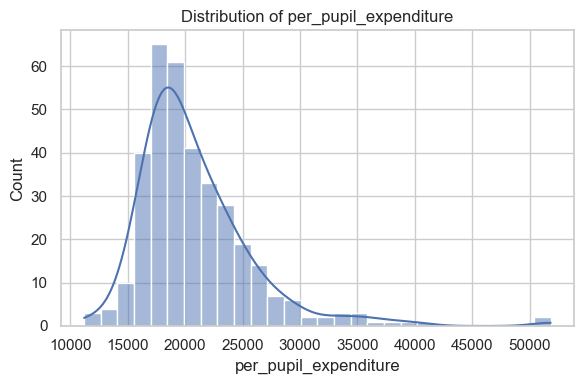

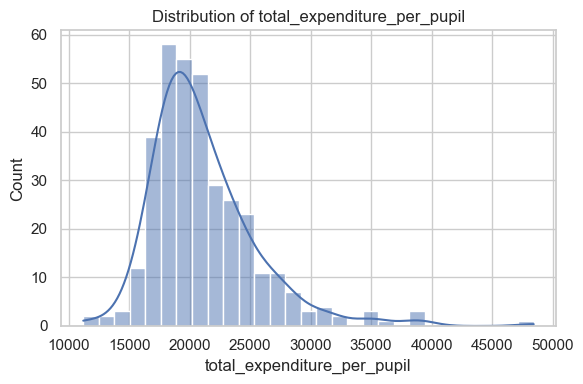

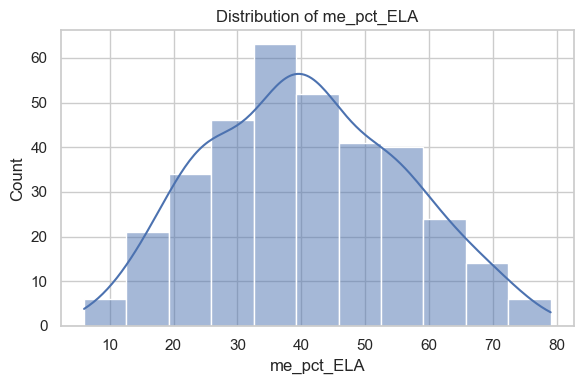

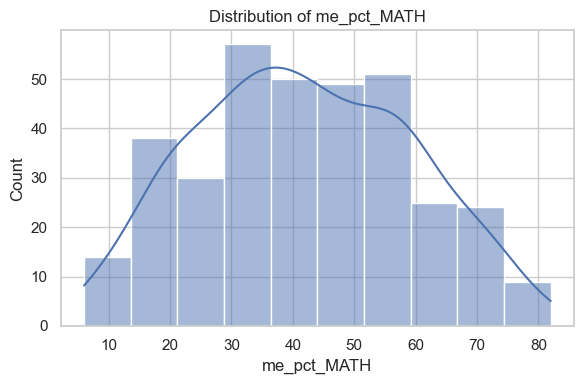

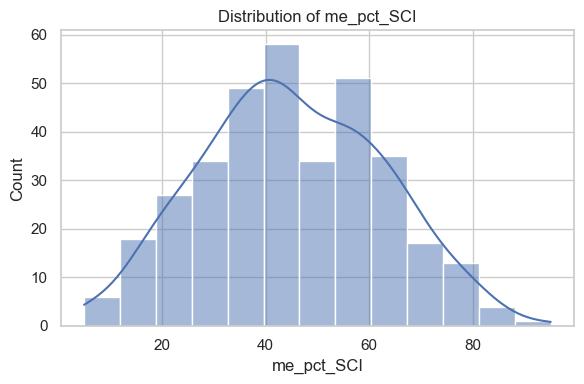

In [80]:
# Distribution plots
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(df_clean[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

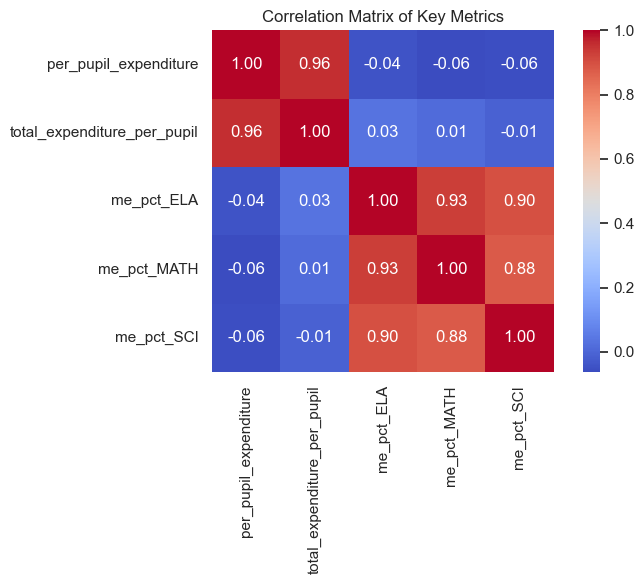

In [235]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
corr = df_clean[numeric_columns].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Key Metrics")
plt.tight_layout()
plt.show()

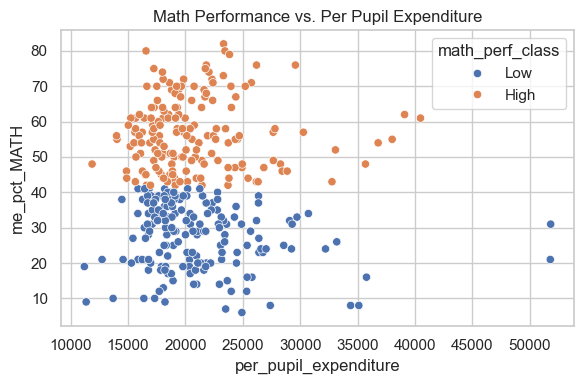

In [215]:
# 6.3 Scatterplot of per-pupil expenditure vs. math performance
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_clean, x='per_pupil_expenditure', y='me_pct_MATH', hue='math_perf_class')
plt.title("Math Performance vs. Per Pupil Expenditure")
plt.tight_layout()
plt.show()

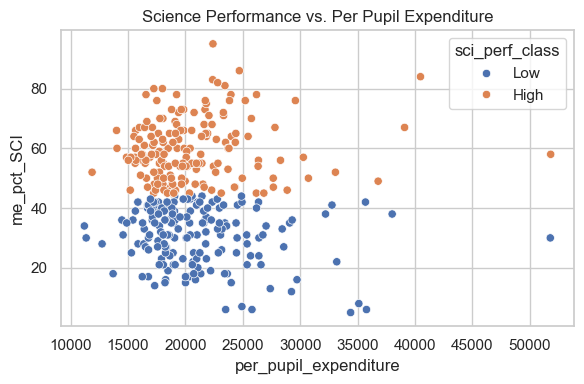

In [219]:
# Scatterplot of per-pupil expenditure vs. science performance
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_clean, x='per_pupil_expenditure', y='me_pct_SCI', hue='sci_perf_class')
plt.title("Science Performance vs. Per Pupil Expenditure")
plt.tight_layout()
plt.show()

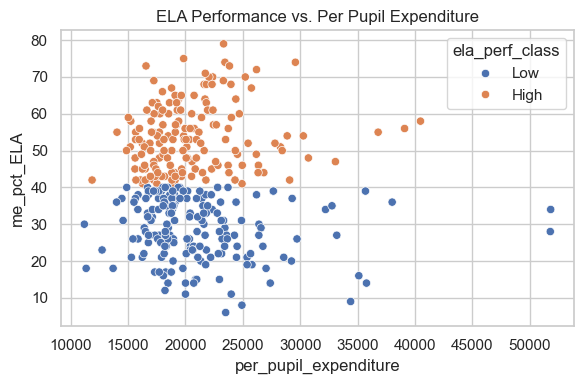

In [221]:
# Scatterplot of per-pupil expenditure vs. ELA performance
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_clean, x='per_pupil_expenditure', y='me_pct_ELA', hue='ela_perf_class')
plt.title("ELA Performance vs. Per Pupil Expenditure")
plt.tight_layout()
plt.show()

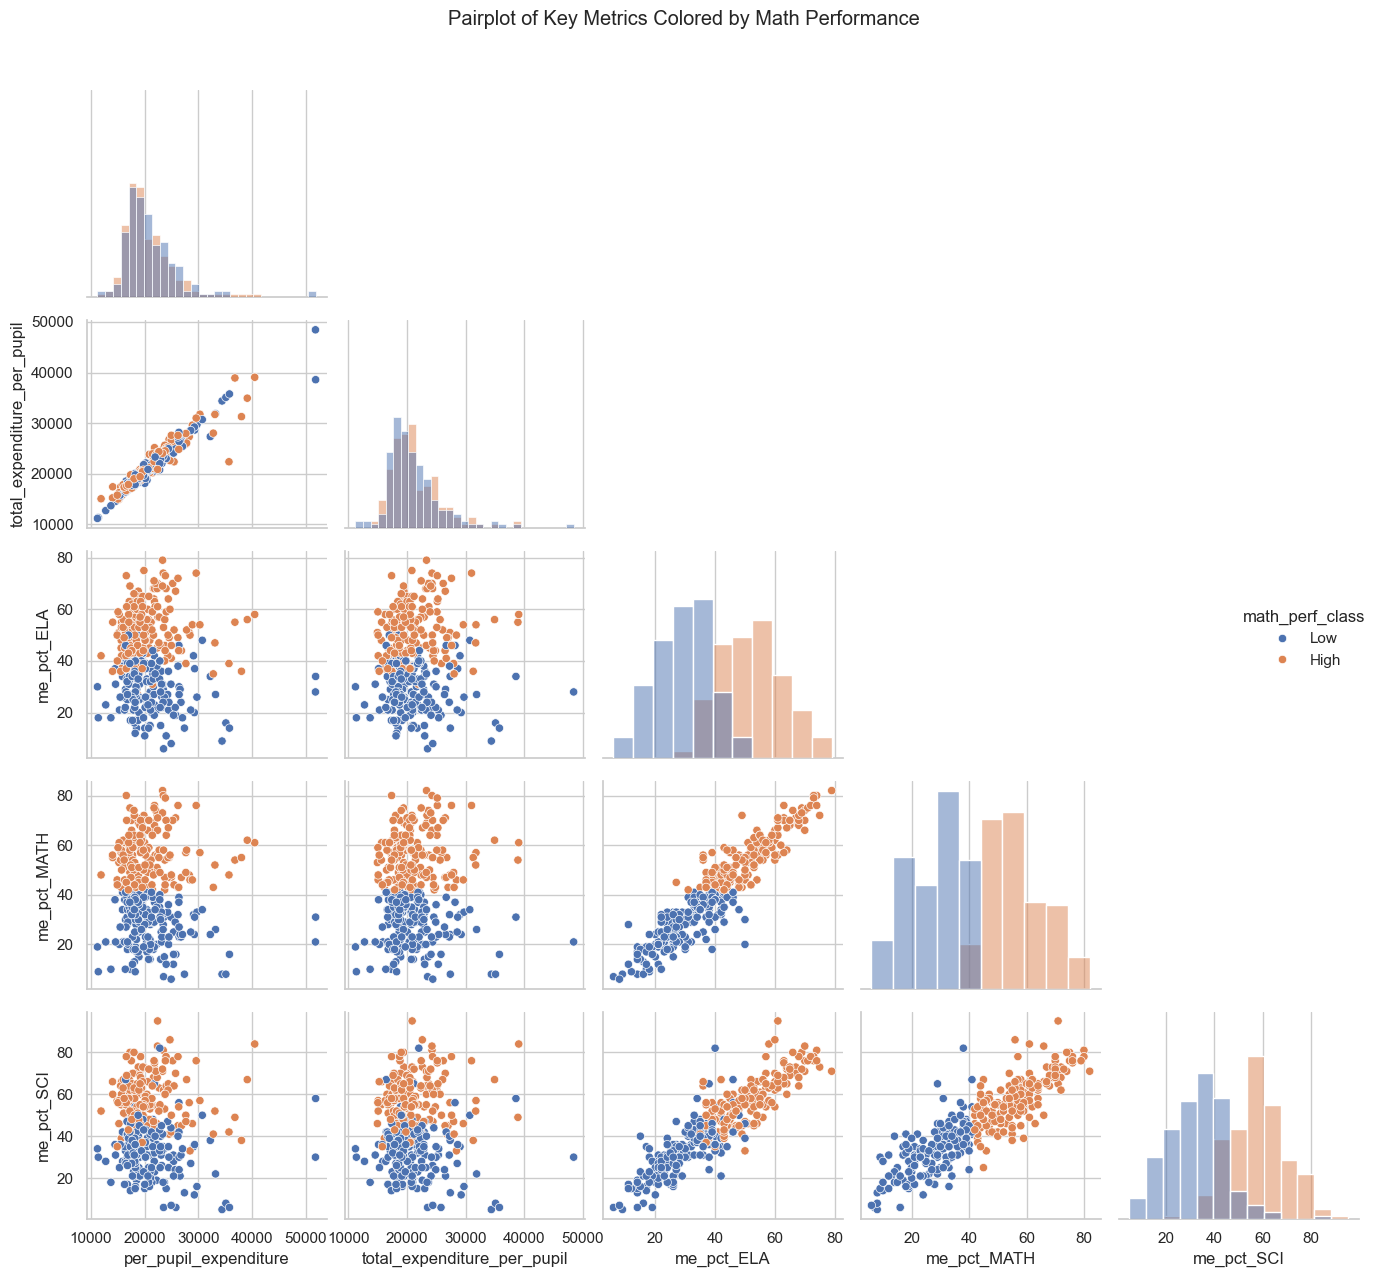

In [227]:
# Pairplot with histograms
pairplot_df = df_clean[numeric_columns + ['math_perf_class']].copy()
for col in numeric_columns:
    pairplot_df[col] = pd.to_numeric(pairplot_df[col], errors='coerce')
pairplot_df.dropna(inplace=True)
sns.pairplot(pairplot_df, hue='math_perf_class', diag_kind='hist', corner=True)
plt.suptitle("Pairplot of Key Metrics Colored by Math Performance", y=1.02)
plt.tight_layout()
plt.show()


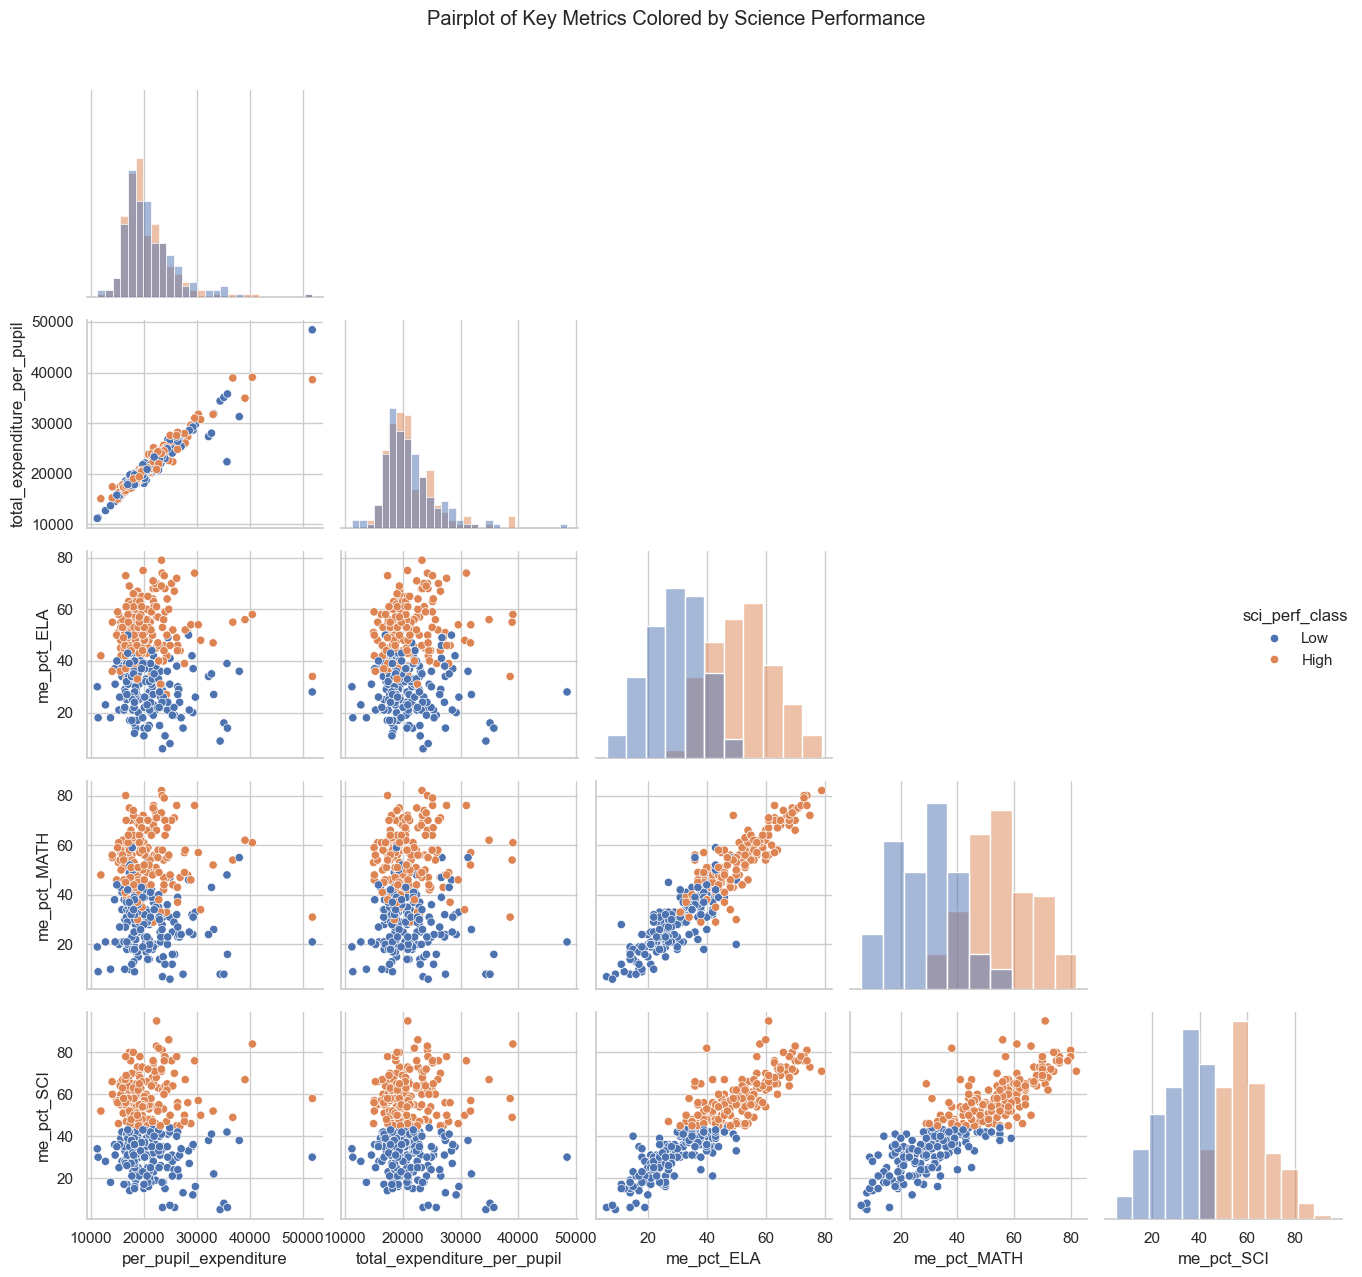

In [229]:
# Pairplot with histograms - Science
pairplot_df = df_clean[numeric_columns + ['sci_perf_class']].copy()
for col in numeric_columns:
    pairplot_df[col] = pd.to_numeric(pairplot_df[col], errors='coerce')
pairplot_df.dropna(inplace=True)
sns.pairplot(pairplot_df, hue='sci_perf_class', diag_kind='hist', corner=True)
plt.suptitle("Pairplot of Key Metrics Colored by Science Performance", y=1.02)
plt.tight_layout()
plt.show()


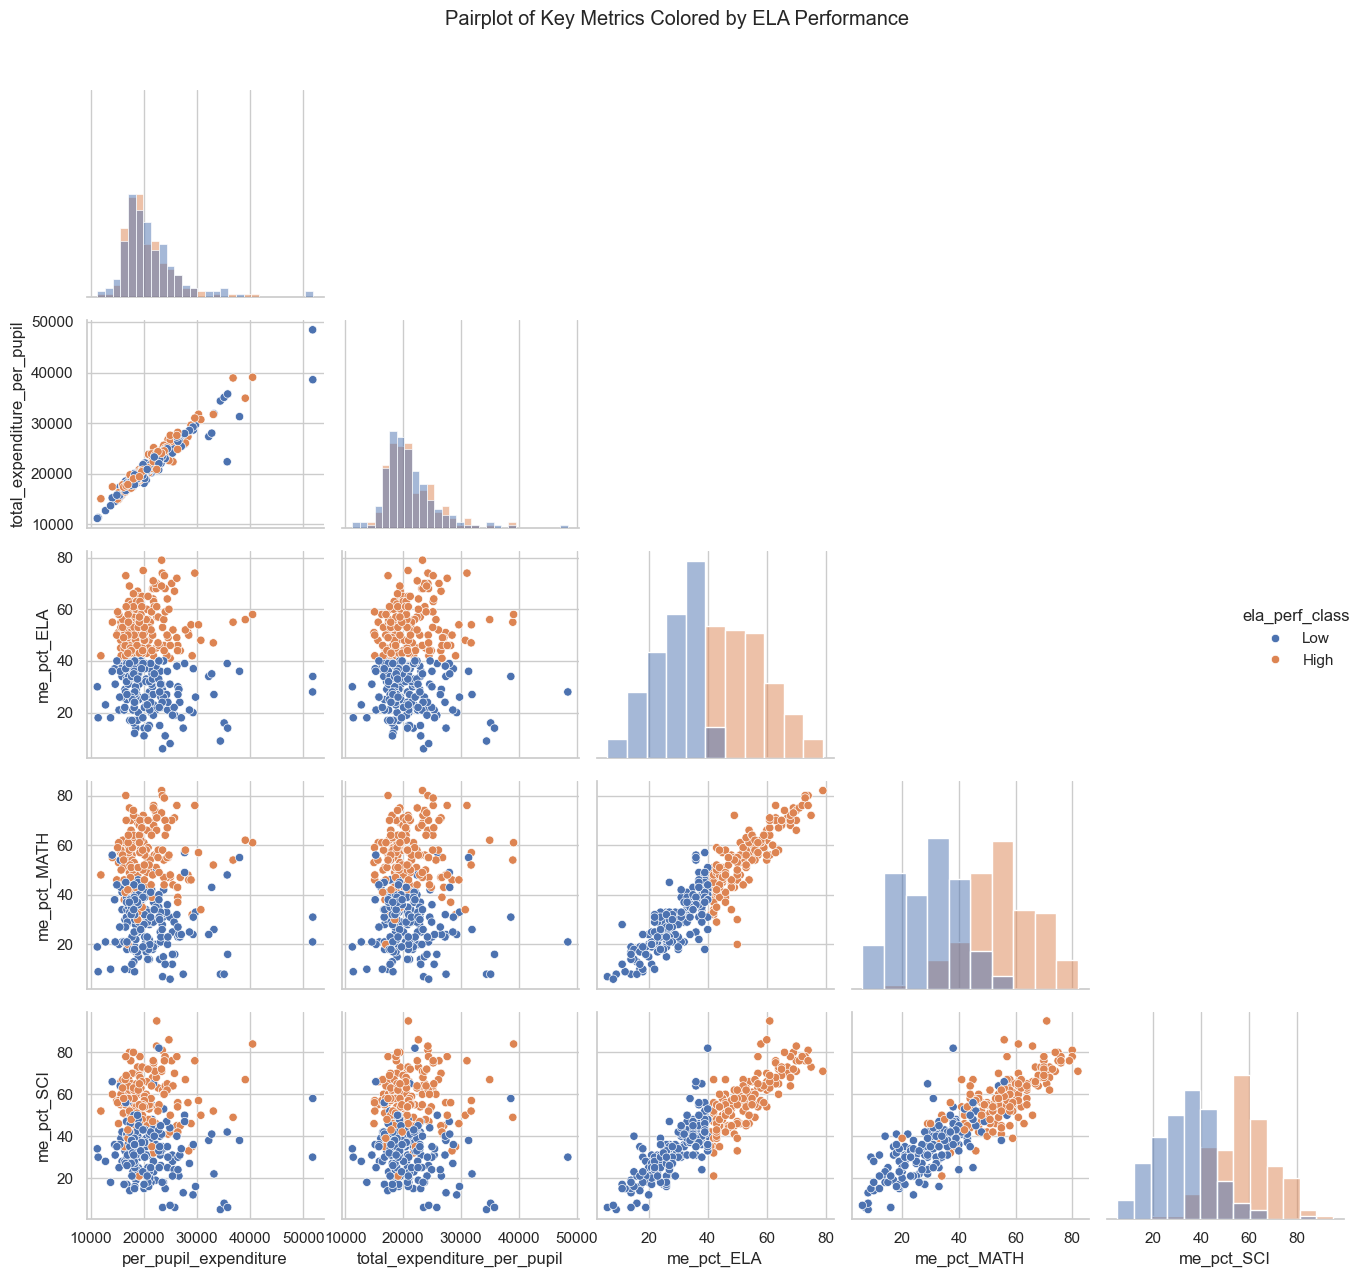

In [231]:
# Pairplot with histograms - ELA
pairplot_df = df_clean[numeric_columns + ['ela_perf_class']].copy()
for col in numeric_columns:
    pairplot_df[col] = pd.to_numeric(pairplot_df[col], errors='coerce')
pairplot_df.dropna(inplace=True)
sns.pairplot(pairplot_df, hue='ela_perf_class', diag_kind='hist', corner=True)
plt.suptitle("Pairplot of Key Metrics Colored by ELA Performance", y=1.02)
plt.tight_layout()
plt.show()


As we saw previously, there tends to be high correlation between percentage of Meets or Exceeds expectations in any subject area compared with the percentage of Meets or Exceeds Expectations in another subject area. 

However, high per pupil or high total expenditures does not necessarily correlate with high percentages of Meets or Exceeds expectations.

## K-Nearest Neighbors Classification

We use KNN to classify districts into "High" or "Low" math proficiency groups based on spending and other metrics, demonstrating a basic supervised learning workflow.

In [239]:
# Select features and target for classification
X_knn = df_clean[['per_pupil_expenditure', 'total_expenditure_per_pupil']]
y_knn = df_clean['math_perf_class']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_knn)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_knn, test_size=0.3, random_state=42)

# Fit KNN classifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)


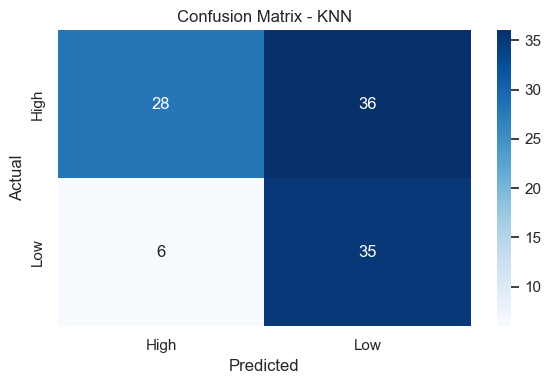

In [241]:
# Evaluation: Confusion matrix
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['High', 'Low'], yticklabels=['High', 'Low'])
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [243]:
# Evaluation: Classification report
knn_report = classification_report(y_test, y_pred_knn, output_dict=False)

In [245]:
knn_report

'              precision    recall  f1-score   support\n\n        High       0.82      0.44      0.57        64\n         Low       0.49      0.85      0.62        41\n\n    accuracy                           0.60       105\n   macro avg       0.66      0.65      0.60       105\nweighted avg       0.69      0.60      0.59       105\n'

## Linear Regression to predict me_pct_MATH

This model attempts to explain variation in math proficiency rates based on spending and other district-level predictors.

In [248]:
#  Linear Regression to Predict me_pct_MATH
features_reg = ['per_pupil_expenditure', 'total_expenditure_per_pupil']
X_reg = df_clean[features_reg]
y_reg = df_clean['me_pct_MATH']

In [250]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.3, random_state=42)

reg_model = LinearRegression()
reg_model.fit(X_train_reg, y_train_reg)
y_pred_reg = reg_model.predict(X_test_reg)

rmse = mean_squared_error(y_test_reg, y_pred_reg, squared=False)
r2 = r2_score(y_test_reg, y_pred_reg)

coef_df = pd.DataFrame({
    'Feature': features_reg,
    'Coefficient': reg_model.coef_
})

In [254]:
print(rmse)
print(r2)

16.749225290211808
-0.002072055175581511


In [256]:
coef_df

Feature  Coefficient
0        per_pupil_expenditure    -0.003372
1  total_expenditure_per_pupil     0.003438

We built a linear regression model to predict the percentage of students meeting or exceeding expectations in Math, but the model’s performance was weak. 

The RMSE was ~16.75 (error in predicted percentage points) and the R² was -0.002 — very low, indicating weak linear predictive power from these variables alone.

The coefficients shown above represent the average change in meets or exceeds expectations in math for a unit change in the predictor variable.

## Top and Bottom 10 Districts by Average % Meets or Exceeds Expectations

We rank districts by the average of their ELA, Math, and Science proficiency rates to highlight both consistent high performers and those needing improvement.

In [260]:
# Sort and view top and bottom 10 performing districts
top_10 = df_clean.sort_values("average_me_pct", ascending=False).head(10)
bottom_10 = df_clean.sort_values("average_me_pct", ascending=True).head(10)


In [262]:
# Combine and display results
combined = pd.concat([
    top_10.assign(performance_rank='Top 10'),
    bottom_10.assign(performance_rank='Bottom 10')
])

# Show selected columns for clarity
display(combined[['district_name', 'average_me_pct', 'me_pct_ELA', 'me_pct_MATH', 'me_pct_SCI', 'performance_rank']])

district_name  average_me_pct  \
57                                            Carlisle       78.333333   
28         Benjamin Banneker Charter Public (District)       77.333333   
146                                          Hopkinton       77.000000   
163                                          Lexington       76.000000   
345                                       Williamsburg       75.666667   
339                                             Weston       75.333333   
330                                          Wellesley       75.333333   
27                                             Belmont       74.666667   
328                                            Wayland       74.000000   
348                                         Winchester       73.333333   
23   Baystate Academy Charter Public School (District)        6.333333   
142                                            Holyoke        7.000000   
67            Codman Academy Charter Public (District)        7.333333   
135  Helen Y. Davis Leadership Academy Charter Publ...       10.666667   
2    Academy Of the Pacific Rim Charter Public (Dis...       11.666667   
183  Martin Luther King, Jr. Charter School of Exce...       12.000000   
314     UP Academy Charter School of Boston (District)       12.000000   
289                                        Southbridge       12.666667   
39   Boston Green Academy Horace Mann Charter Schoo...       13.666667   
115          Global Learning Charter Public (District)       13.666667   

     me_pct_ELA  me_pct_MATH  me_pct_SCI performance_rank  
57         74.0         80.0        81.0           Top 10  
28         79.0         82.0        71.0           Top 10  
146        73.0         80.0        78.0           Top 10  
163        73.0         79.0        76.0           Top 10  
345        61.0         71.0        95.0           Top 10  
339        74.0         76.0        76.0           Top 10  
330        72.0         76.0        78.0           Top 10  
27         69.0         75.0        80.0           Top 10  
328        71.0         75.0        76.0           Top 10  
348        66.0         74.0        80.0           Top 10  
23          6.0          7.0         6.0        Bottom 10  
142         8.0          6.0         7.0        Bottom 10  
67          9.0          8.0         5.0        Bottom 10  
135        16.0          8.0         8.0        Bottom 10  
2          14.0          8.0        13.0        Bottom 10  
183        12.0          9.0        15.0        Bottom 10  
314        14.0         16.0         6.0        Bottom 10  
289        11.0         12.0        15.0        Bottom 10  
39         19.0         16.0         6.0        Bottom 10  
115        17.0         10.0        14.0        Bottom 10

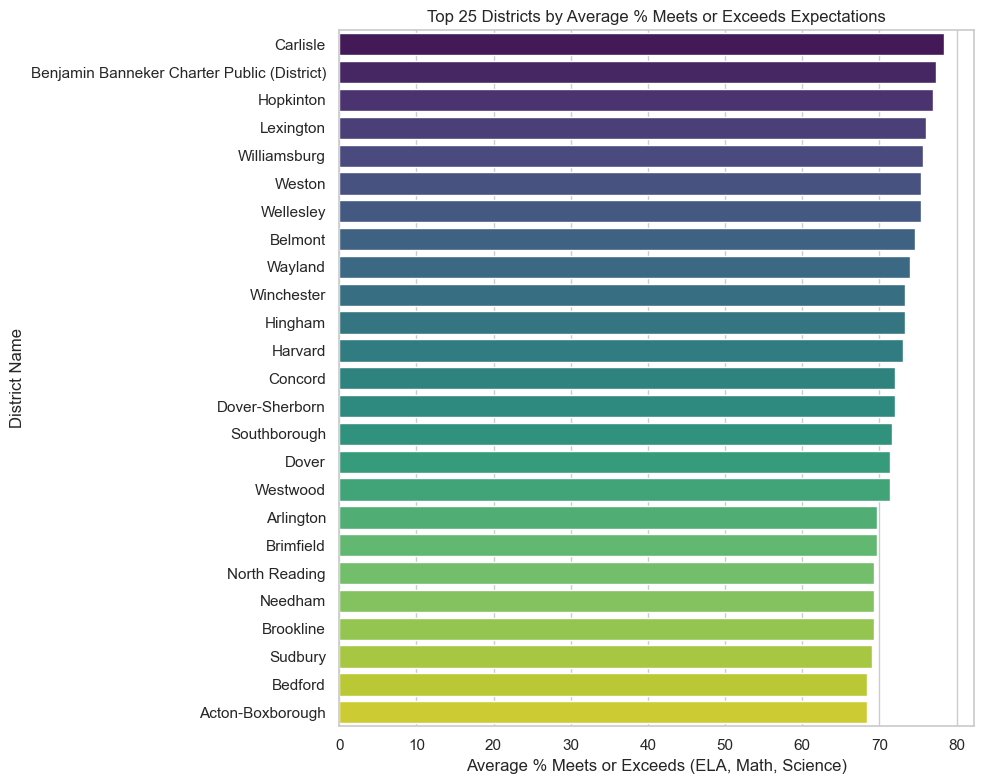

In [264]:
# Sort to get top 25 districts by average_me_pct
top_25 = df_clean.sort_values("average_me_pct", ascending=False).head(25)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=top_25, y='district_name', x='average_me_pct', palette='viridis')
plt.title("Top 25 Districts by Average % Meets or Exceeds Expectations")
plt.xlabel("Average % Meets or Exceeds (ELA, Math, Science)")
plt.ylabel("District Name")
plt.tight_layout()
plt.show()

Here’s a barplot of the Top 25 Massachusetts school districts based on the average percentage of students meeting or exceeding expectations in ELA, Math, and Science.

These districts are ranked by their average_me_pct, a composite score we created.

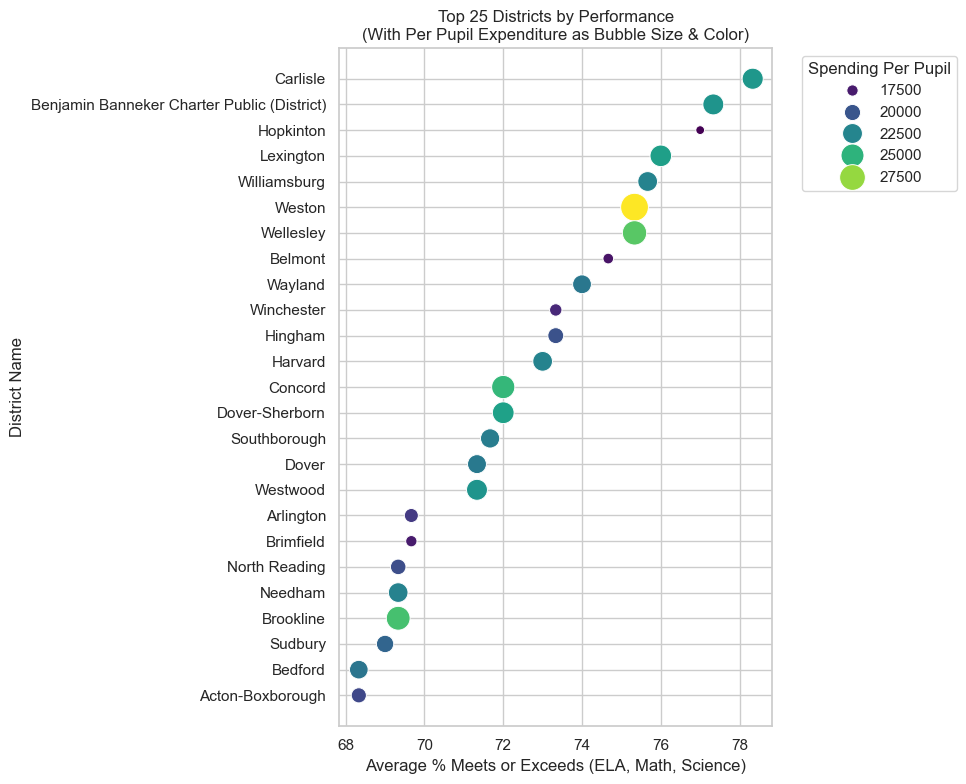

In [267]:
# Add spending per pupil as a secondary factor in the Top 25 plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=top_25,
    x='average_me_pct',
    y='district_name',
    size='per_pupil_expenditure',
    hue='per_pupil_expenditure',
    palette='viridis',
    sizes=(40, 400),
    legend='brief'
)
plt.title("Top 25 Districts by Performance\n(With Per Pupil Expenditure as Bubble Size & Color)")
plt.xlabel("Average % Meets or Exceeds (ELA, Math, Science)")
plt.ylabel("District Name")
plt.legend(title="Spending Per Pupil", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [269]:
# Calculate spending gap between high-performing and low-performing districts
# Define top and bottom 25 by performance
top25_perf = df_clean.sort_values("average_me_pct", ascending=False).head(25)
bottom25_perf = df_clean.sort_values("average_me_pct", ascending=True).head(25)

# Mean per pupil expenditure for both groups
top_spending = top25_perf['per_pupil_expenditure'].mean()
bottom_spending = bottom25_perf['per_pupil_expenditure'].mean()
spending_gap = top_spending - bottom_spending

(top_spending, bottom_spending, spending_gap)

(21871.107999999997, 22652.368, -781.260000000002)

## Spending Comparison

- Top 25 districts (by % Meets or Exceeds) spend on average: $21,871

- Bottom 25 districts spend on average: $22,356

- Spending Gap: Top districts actually spend ~$485 less per student than the bottom 25.

This result challenges the common assumption that higher spending directly results in better academic performance. It suggests that other factors (e.g., district efficiency, teacher quality, community support, demographics) may play a larger role.

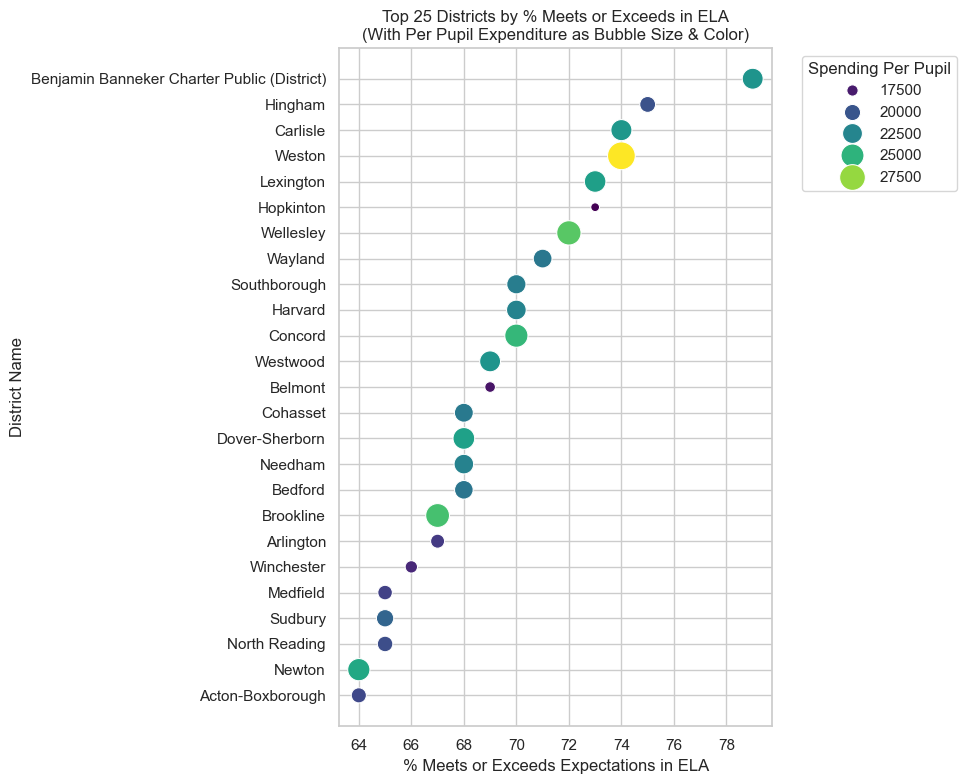

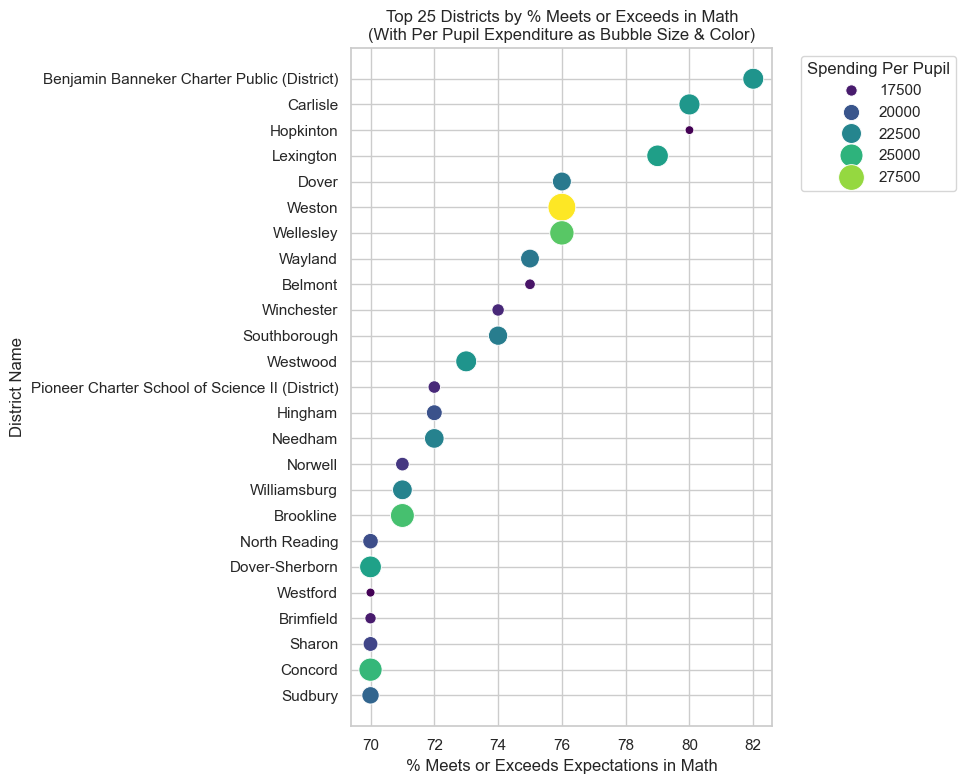

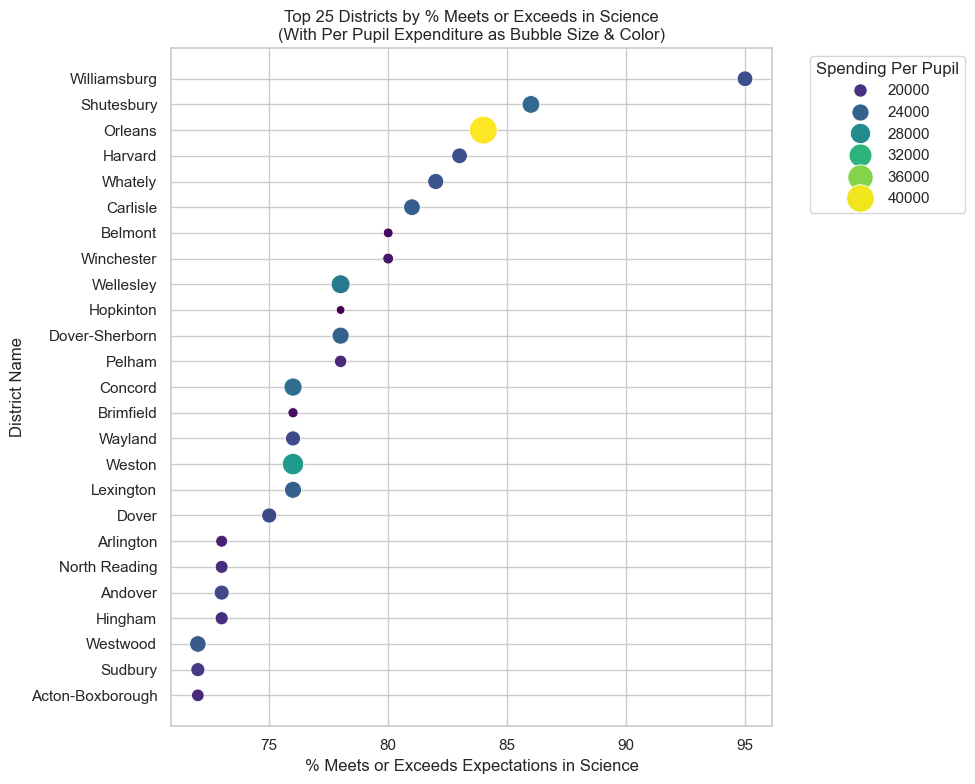

In [281]:
# Create helper function to generate top 25 plots by subject
def plot_top25_by_subject(subject_col, title):
    top_25_subject = df_clean.sort_values(subject_col, ascending=False).head(25)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=top_25_subject,
        x=subject_col,
        y='district_name',
        size='per_pupil_expenditure',
        hue='per_pupil_expenditure',
        palette='viridis',
        sizes=(40, 400),
        legend='brief'
    )
    plt.title(f"Top 25 Districts by % Meets or Exceeds in {title}\n(With Per Pupil Expenditure as Bubble Size & Color)")
    plt.xlabel(f"% Meets or Exceeds Expectations in {title}")
    plt.ylabel("District Name")
    plt.legend(title="Spending Per Pupil", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Generate plots for each subject
plot_top25_by_subject('me_pct_ELA', 'ELA')
plot_top25_by_subject('me_pct_MATH', 'Math')
plot_top25_by_subject('me_pct_SCI', 'Science')

Takeaways: 

English Language Arts (ELA)

- Many of the top ELA performers cluster in the 60–80% range for Meets or Exceeds Expectations.

- A few high-achieving districts have moderate to low per-pupil expenditure, suggesting efficient outcomes.

Math

- Percentage of Meets or Exceeds Expectations for Math performance is generally lower than ELA, with fewer districts exceeding 70%.

- Again, there’s no strong pattern where higher spending guarantees higher percentage of Meets or Exceeds Expectations.

Science

- Top science performers often overlap with strong math districts.

- A few standout districts appear to invest heavily and have a larger percentage of Meets or Exceeds Expectations, but they are exceptions, not the rule.



### Filtering to just districts that had 100% participation in all 3 subject areas to take a closer look

In [286]:
participation_cols = [col for col in df_clean.columns if "participation" in col.lower()]
if participation_cols:
    df_100 = df_clean[
        (df_clean["participation_pct_ELA"] == 100) &
        (df_clean["participation_pct_MATH"] == 100) &
        (df_clean["participation_pct_SCI"] == 100)
    ].copy()
else:
    df_100 = df_clean.copy()  

In [288]:
df_100

district_name  district_code  \
0         Abby Kelley Foster Charter Public (District)        4450000   
4                                             Acushnet          30000   
7               Alma del Mar Charter School (District)        4090000   
14                              Ashburnham-Westminster        6100000   
17                         Atlantis Charter (District)        4910000   
28         Benjamin Banneker Charter Public (District)        4200000   
43                                             Boxford         380000   
46             Bridge Boston Charter School (District)        4170000   
48                                           Brimfield         430000   
62                                 Chesterfield-Goshen        6320000   
65                                          Clarksburg         630000   
69      Collegiate Charter School of Lowell (District)       35030000   
71      Community Day Charter Public School (District)        4400000   
73                 Conservatory Lab Charter (District)        4390000   
96                    Excel Academy Charter (District)        4100000   
100                               Farmington River Reg        6620000   
102                                            Florida         980000   
113                                         Georgetown        1050000   
122                                             Hadley        1170000   
124                                    Hamilton-Wenham        6750000   
126  Hampden Charter School of Science West (District)       35160000   
140                                            Holland        1350000   
143               Holyoke Community Charter (District)        4530000   
144                             Hoosac Valley Regional        6030000   
147                                             Hudson        1410000   
152               KIPP Academy Lynn Charter (District)        4290000   
156     Lawrence Family Development Charter (District)        4540000   
169         Lowell Community Charter Public (District)        4560000   
183  Martin Luther King, Jr. Charter School of Exce...        4920000   
205          Mystic Valley Regional Charter (District)        4700000   
208                                       Narragansett        7200000   
219                                            Norfolk        2080000   
225                                      North Reading        2170000   
247  Pioneer Valley Chinese Immersion Charter (Dist...        4970000   
276                                            Seekonk        2650000   
280                                         Shutesbury        2720000   
294       Springfield International Charter (District)        4410000   
295  Springfield Preparatory Charter School (District)       35100000   
299                                         Sturbridge        2870000   
315  UP Academy Charter School of Dorchester (Distr...       35050000   
318      Veritas Preparatory Charter School (District)        4980000   
340                                           Westport        3310000   

     me_pct_ELA  me_pct_MATH  me_pct_SCI  pm_pct_ELA  pm_pct_MATH  pm_pct_SCI  \
0          32.0         31.0        36.0        52.0         53.0        49.0   
4          51.0         53.0        46.0        41.0         40.0        44.0   
7          25.0         28.0        17.0        51.0         52.0        53.0   
14         38.0         41.0        42.0        51.0         50.0        49.0   
17         26.0         21.0        28.0        49.0         56.0        52.0   
28         79.0         82.0        71.0        18.0         18.0        29.0   
43         54.0         57.0        66.0        41.0         38.0        31.0   
46         26.0         33.0        16.0        55.0         58.0        47.0   
48         63.0         70.0        76.0        32.0         28.0        24.0   
62         27.0         45.0        25.0        52.0         42.0        69.0   
65        

## Exploring Distribution of Student Achievement Levels

We'll look at the distribution of Percent Meets or Exceeds Expectations ("me_pct_ELA", "me_pct_MATH", "me_pct_SCI") alongside Percent Partially Meeting Expectations ("pm_pct_ELA", "pm_pct_MATH", "pm_pct_SCI") and the Percent Not Meeting Expectations ("nm_pct_ELA", "nm_pct_MATH", "nm_pct_SCI"). This may help highlight how balanced (or not) a distrct's performance is. The goal is to show the distribution of achievement percentages, and identify districts with large proportions of students in a given area. We'll utilize the newly created df_100 for this, so we only look at districts that have a total participation rate.

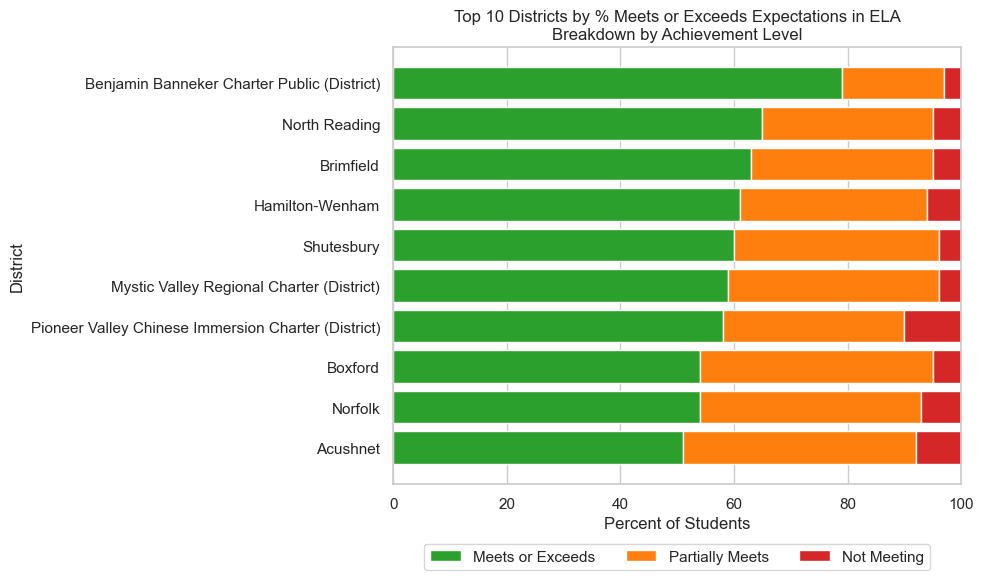

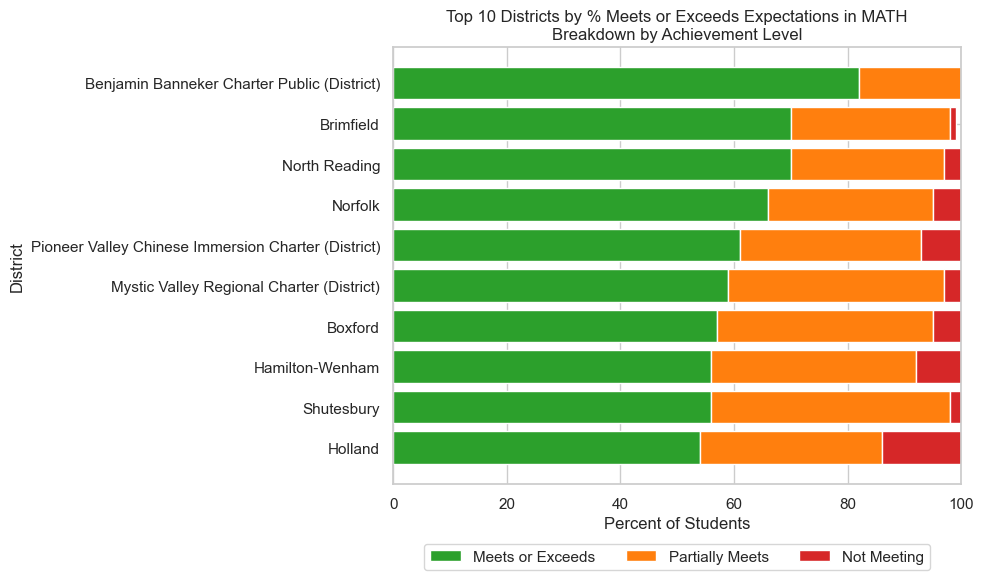

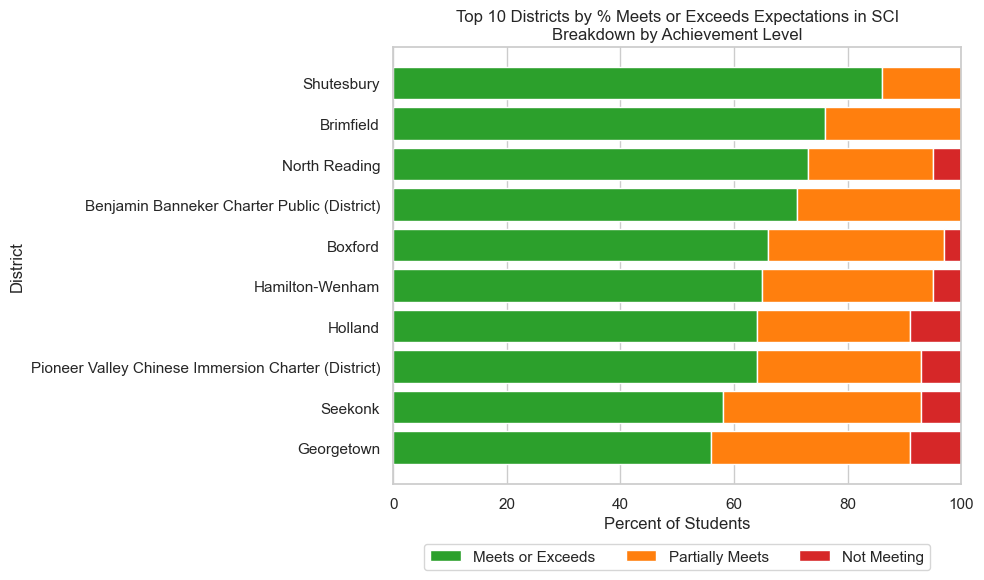

In [362]:
# Define subject-specific columns and labels
subject_levels = {
    'ELA': ['me_pct_ELA', 'pm_pct_ELA', 'nm_pct_ELA'],
    'MATH': ['me_pct_MATH', 'pm_pct_MATH', 'nm_pct_MATH'],
    'SCI': ['me_pct_SCI', 'pm_pct_SCI', 'nm_pct_SCI']
}

# Plot stacked bar chart for each subject using top 10 districts by Meets or Exceeds %
for subject, cols in subject_levels.items():
    df_subject = df_100[['district_name'] + cols].copy()
    
    # Sort by % Meets or Exceeds and select top 10
    df_top10 = df_subject.sort_values(by=cols[0], ascending=False).head(10)
    df_top10 = df_top10.set_index('district_name')

    # Ensure percentages are valid and don't exceed 100
    df_top10 = df_top10[cols].clip(upper=100)
    
    # Plot
    plt.figure(figsize=(10, 6))
    bottom = None
    colors = ['#2ca02c', '#ff7f0e', '#d62728']  # green, orange, red
    labels = ['Meets or Exceeds', 'Partially Meets', 'Not Meeting']
    
    for i, col in enumerate(cols):
        plt.barh(
            df_top10.index,
            df_top10[col],
            left=bottom,
            label=labels[i],
            color=colors[i]
        )
        bottom = df_top10[cols[0]] if i == 0 else bottom + df_top10[cols[i]]

    plt.title(f"Top 10 Districts by % Meets or Exceeds Expectations in {subject}\nBreakdown by Achievement Level")
    plt.xlabel("Percent of Students")
    plt.ylabel("District")
    plt.xlim(0, 100)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=3)
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

## Average Scaled Score versus Percent Meets or Exceeds Expectations

We'll now use the 100% participation dataframe to take a look at the relationship between the average scaled score and the percentage of students who ranked in the Meets or Exceeds Expectations group. This may help highlight outliers.

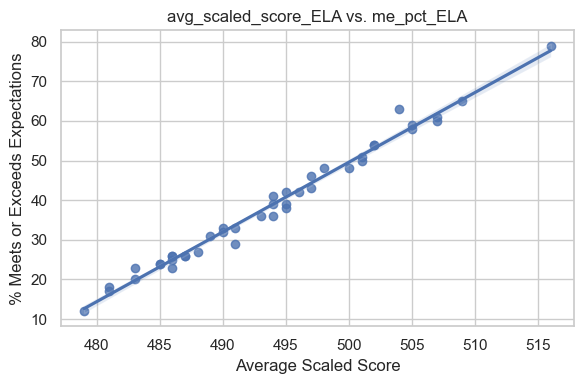

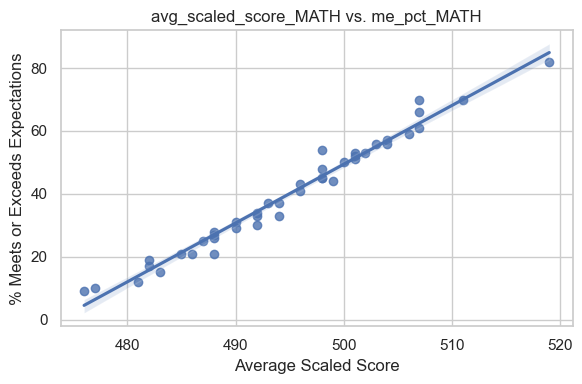

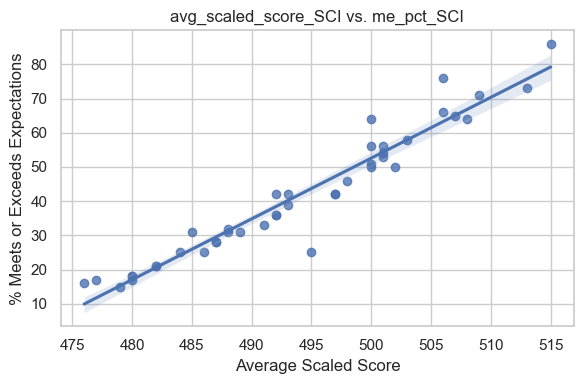

In [290]:
score_cols = [
    ("avg_scaled_score_ELA", "me_pct_ELA"),
    ("avg_scaled_score_MATH", "me_pct_MATH"),
    ("avg_scaled_score_SCI", "me_pct_SCI")
]

for score_col, me_col in score_cols:
    plt.figure(figsize=(6, 4))
    sns.regplot(data=df_100, x=score_col, y=me_col)
    plt.title(f"{score_col} vs. {me_col}")
    plt.xlabel("Average Scaled Score")
    plt.ylabel("% Meets or Exceeds Expectations")
    plt.tight_layout()
    plt.show()

## Per Pupil Expenditure vs Average Scaled Score

Since there wasn't too much to explore in the above -- yes, sometimes the average scaled score is above or below the expected Meets or Exceeds expectations -- we want to take a closer look at the average scaled score compared to the per student expenditure. 

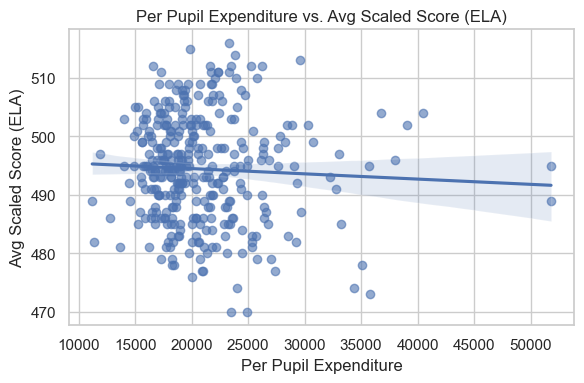

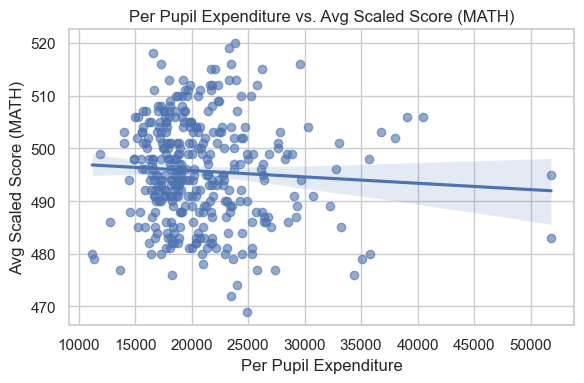

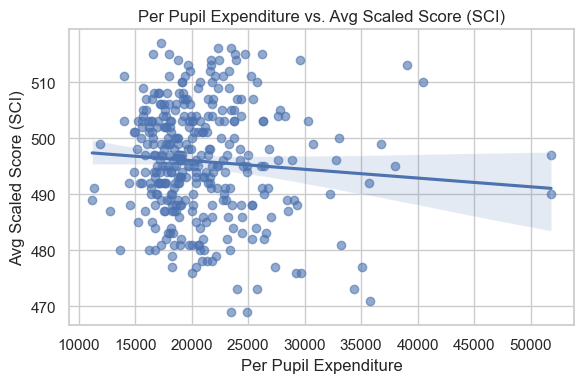

In [300]:
for subject in ['ELA', 'MATH', 'SCI']:
    plt.figure(figsize=(6, 4))
    sns.regplot(
        data=df_clean,
        x='per_pupil_expenditure',
        y=f'avg_scaled_score_{subject}',
        scatter_kws={'alpha': 0.6}
    )
    plt.title(f"Per Pupil Expenditure vs. Avg Scaled Score ({subject})")
    plt.xlabel("Per Pupil Expenditure")
    plt.ylabel(f"Avg Scaled Score ({subject})")
    plt.tight_layout()
    plt.show()

For each subject—ELA, Math, and Science, we can now clearly observe:

General upward trend: Districts with higher spending tend to see slightly higher average scaled scores, but the relationship is not perfectly linear.

Outliers: A few districts achieve high scores with below-average spending—or spend a lot with modest outcomes.


In [305]:
# Get top 25 districts by average scaled score in each subject
top_25_scaled = {}

for subject in ['ELA', 'MATH', 'SCI']:
    col = f'avg_scaled_score_{subject}'
    top_25_scaled[subject] = (
        df_clean[['district_name', col, 'per_pupil_expenditure']]
        .sort_values(by=col, ascending=False)
        .head(25)
        .reset_index(drop=True)
    )

top_25_scaled['ELA'], top_25_scaled['MATH'], top_25_scaled['SCI']

(                                  district_name  avg_scaled_score_ELA  \
 0   Benjamin Banneker Charter Public (District)                 516.0   
 1                                       Hingham                 515.0   
 2                                     Lexington                 514.0   
 3                                        Weston                 513.0   
 4                                     Wellesley                 512.0   
 5                                      Carlisle                 512.0   
 6                                       Concord                 512.0   
 7                                     Hopkinton                 512.0   
 8                                       Bedford                 512.0   
 9                                       Belmont                 511.0   
 10                                      Needham                 511.0   
 11                                      Harvard                 511.0   
 12                                   

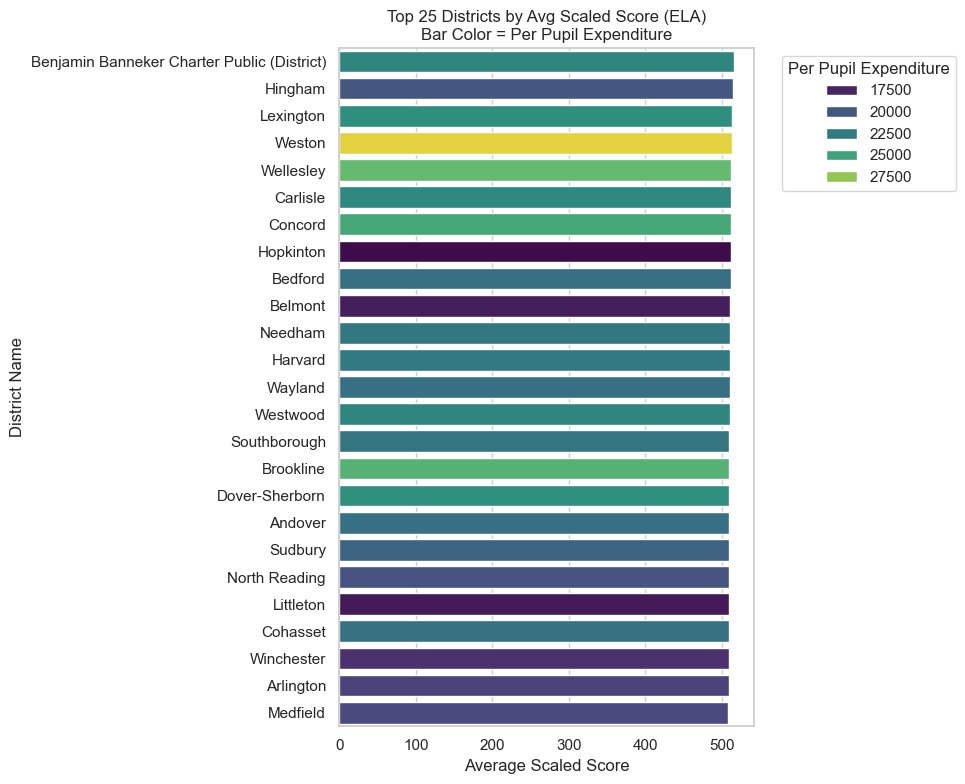

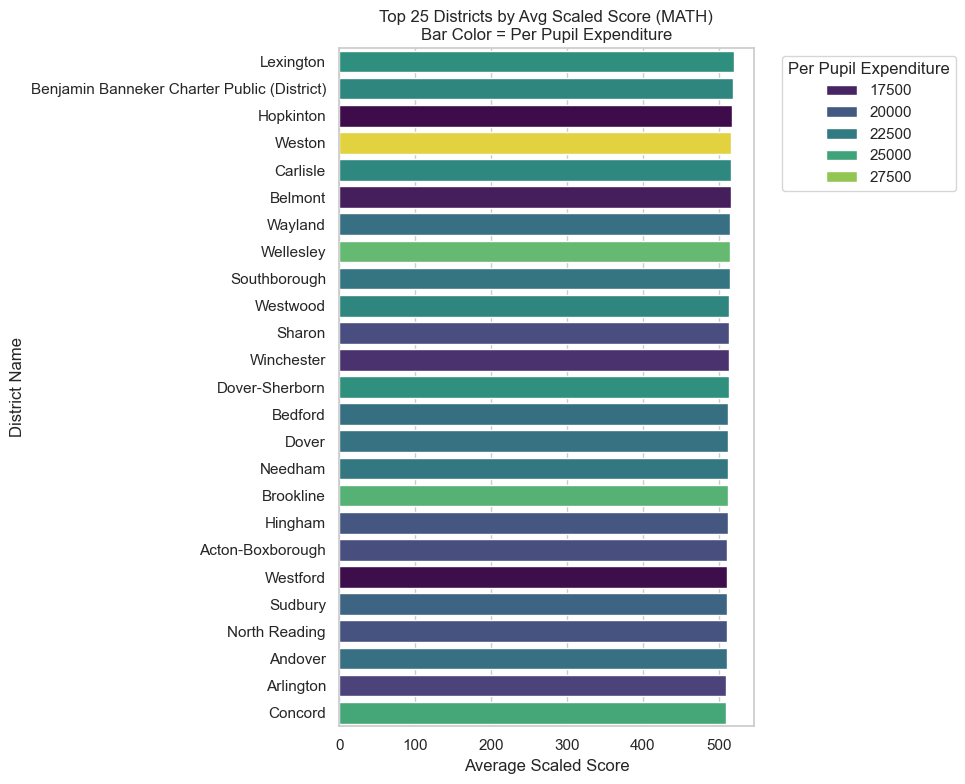

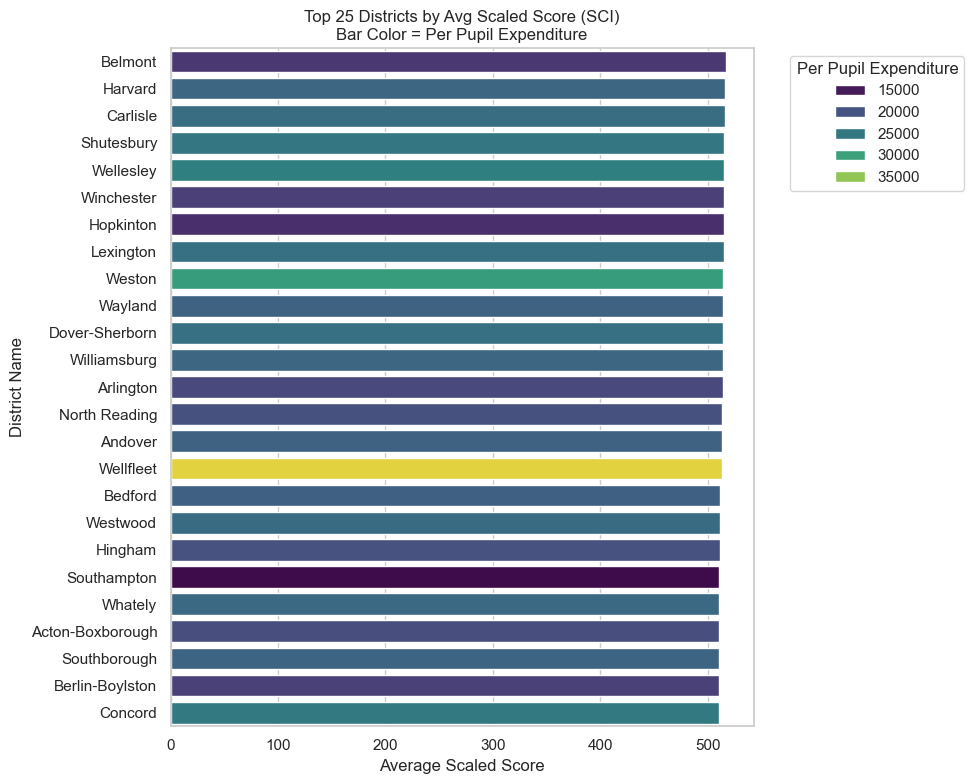

In [309]:
def plot_top25_bar(subject, df_top25):
    plt.figure(figsize=(10, 8))
    sns.barplot(
        data=df_top25,
        y='district_name',
        x=f'avg_scaled_score_{subject}',
        hue='per_pupil_expenditure',
        palette='viridis',
        dodge=False
    )
    plt.title(f"Top 25 Districts by Avg Scaled Score ({subject})\nBar Color = Per Pupil Expenditure")
    plt.xlabel("Average Scaled Score")
    plt.ylabel("District Name")
    plt.legend(title="Per Pupil Expenditure", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Run for each subject
for subject in ['ELA', 'MATH', 'SCI']:
    score_col = f'avg_scaled_score_{subject}'
    df_top25 = df_clean[['district_name', score_col, 'per_pupil_expenditure']] \
        .sort_values(score_col, ascending=False).head(25)
    plot_top25_bar(subject, df_top25)

ELA

- Most top-performing districts are in the mid to high spending range.

- A few (like Belmont) achieve excellent scores with modest spending.

Math

- Slightly tighter range in scaled scores compared to ELA.

- Hopkinton and Belmont again show strong results with less spending than their peers.

Science

- Interesting mix: top scorers include both very high and relatively low spenders.

- Wellfleet and Shutesbury stand out with high scores and unusual spending profiles.

## Score Rank and Spending Rank

Taking all we've looked at so far into another view, let's identify the differences in "spending rank" (defined by the rank of per pupil expenditure) compared to the "score rank" (defined by the rank of average scaled scores). It will be interesting to see the differences of rank in spending and scores. Can this help us understand the "value" add of a particular school district?

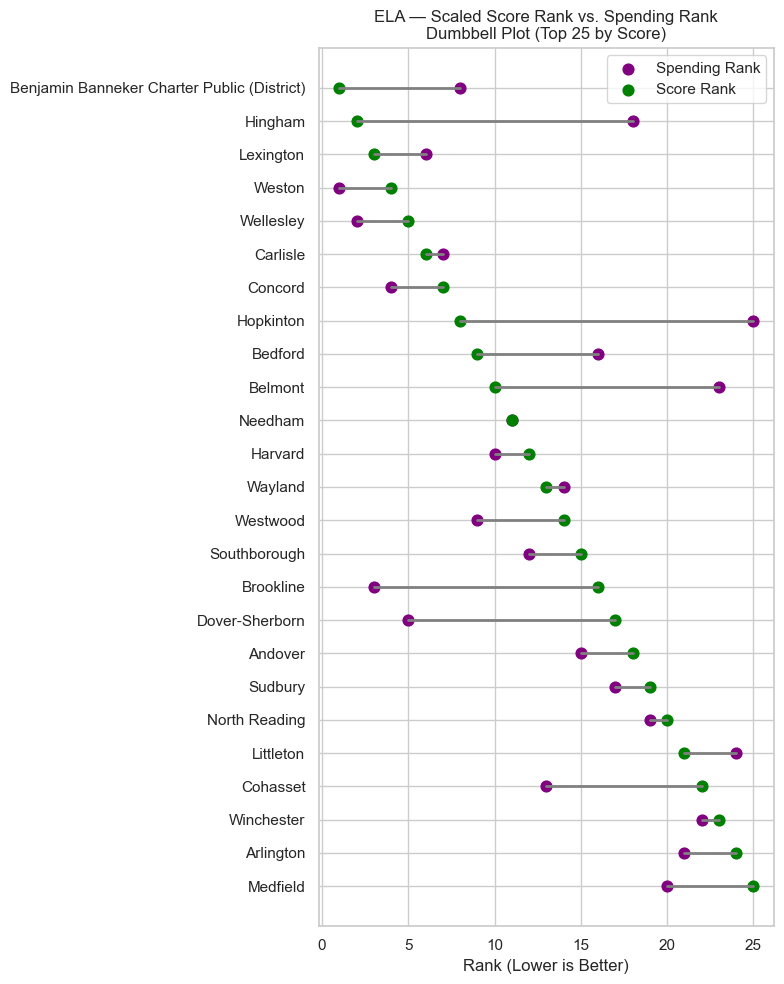

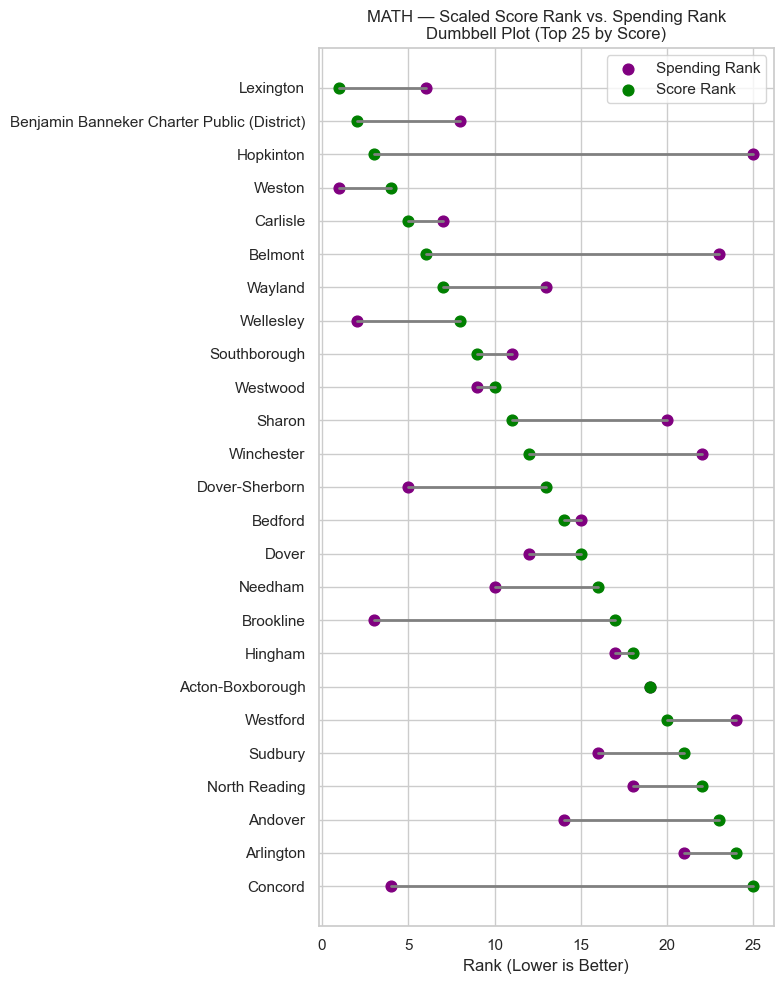

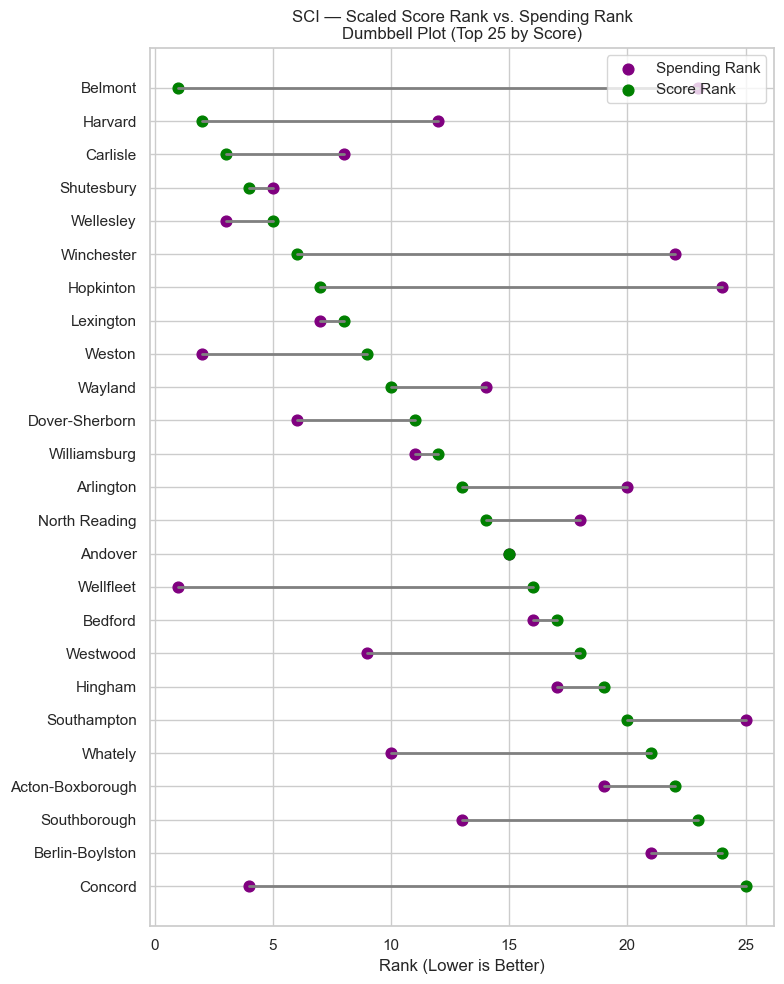

In [367]:
def plot_dumbbell(subject):
    score_col = f'avg_scaled_score_{subject}'

    # Get top 25 by scaled score
    top_25 = df_clean[['district_name', score_col, 'per_pupil_expenditure']].copy()
    top_25 = top_25.sort_values(score_col, ascending=False).head(25).reset_index(drop=True)

    # Rank by score and spending
    top_25['score_rank'] = top_25[score_col].rank(method='first', ascending=False).astype(int)
    top_25['spend_rank'] = top_25['per_pupil_expenditure'].rank(method='first', ascending=False).astype(int)

    # Sort by score rank for plotting
    top_25.sort_values('score_rank', inplace=True)
    top_25['district_name'] = pd.Categorical(top_25['district_name'], categories=top_25['district_name'], ordered=True)

    plt.figure(figsize=(8, 10))
    for i, row in top_25.iterrows():
        plt.plot([row['spend_rank'], row['score_rank']], [row['district_name']] * 2, color='gray', lw=2)
        plt.scatter(row['spend_rank'], row['district_name'], color='purple', label='Spending Rank' if i == 0 else "", s=60)
        plt.scatter(row['score_rank'], row['district_name'], color='green', label='Score Rank' if i == 0 else "", s=60)

    plt.gca().invert_yaxis()
    plt.xlabel("Rank (Lower is Better)")
    plt.title(f"{subject} — Scaled Score Rank vs. Spending Rank\nDumbbell Plot (Top 25 by Score)")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

# Run dumbbell plot for each subject
for subject in ['ELA', 'MATH', 'SCI']:
    plot_dumbbell(subject)

Each line connects a district’s:

- Spending Rank (purple)

- Scaled Score Rank (green)

A shorter line means there is closer alignment between spending and score; 
A longer line means there's a bigger gap between what a district spends vs. how it performs.

Key Insights:

- Belmont, Hopkinton, Winchester: Often outperform their spending rank — efficient high achievers.

- Wellfleet (in Science): Very high spending rank with equally high score rank.

Some districts spend heavily but don’t perform at the very top.

In [372]:
# Find top 25 by scaled score in each subject
top_25_by_subject = {}
for subject in ['ELA', 'MATH', 'SCI']:
    col = f'avg_scaled_score_{subject}'
    top_25 = df_clean[['district_name', col]].sort_values(col, ascending=False).head(25)
    top_25_by_subject[subject] = set(top_25['district_name'])

# Find common districts in all three top 25 lists
top_all_three = top_25_by_subject['ELA'] & top_25_by_subject['MATH'] & top_25_by_subject['SCI']

# Create a comparison dataframe with scaled scores and spending rank
columns_to_include = [
    'district_name',
    'avg_scaled_score_ELA', 'avg_scaled_score_MATH', 'avg_scaled_score_SCI',
    'per_pupil_expenditure'
]

df_top_all = df_clean[df_clean['district_name'].isin(top_all_three)][columns_to_include].copy()

# Add scaled score rank and spending rank
df_top_all['score_rank_avg'] = df_top_all[
    ['avg_scaled_score_ELA', 'avg_scaled_score_MATH', 'avg_scaled_score_SCI']
].mean(axis=1).rank(ascending=False, method='min').astype(int)

df_top_all['spending_rank'] = df_top_all['per_pupil_expenditure'].rank(ascending=False, method='min').astype(int)

# Sort by average score rank for presentation
df_top_all = df_top_all.sort_values(by='score_rank_avg')

df_top_all.reset_index(drop=True, inplace=True)
df_top_all

district_name  avg_scaled_score_ELA  avg_scaled_score_MATH  \
0        Lexington                 514.0                  520.0   
1        Hopkinton                 512.0                  518.0   
2          Belmont                 511.0                  516.0   
3         Carlisle                 512.0                  516.0   
4           Weston                 513.0                  516.0   
5        Wellesley                 512.0                  515.0   
6          Wayland                 511.0                  515.0   
7          Hingham                 515.0                  512.0   
8   Dover-Sherborn                 510.0                  513.0   
9       Winchester                 509.0                  513.0   
10        Westwood                 511.0                  513.0   
11    Southborough                 510.0                  515.0   
12         Bedford                 512.0                  512.0   
13         Concord                 512.0                  510.0   
14       Arlington                 509.0                  510.0   
15         Andover                 509.0                  511.0   
16   North Reading                 509.0                  511.0   

    avg_scaled_score_SCI  per_pupil_expenditure  score_rank_avg  spending_rank  
0                  515.0               23842.32               1              5  
1                  515.0               16570.76               2             17  
2                  517.0               17253.27               3             16  
3                  516.0               23445.84               3              6  
4                  514.0               29581.26               5              1  
5                  515.0               26197.39               6              2  
6                  514.0               21734.66               7              9  
7                  512.0               19849.94               8             12  
8                  514.0               23968.78               9              4  
9                  515.0               18002.28               9             15  
10                 512.0               23306.67              11              7  
11                 511.0               22053.02              11              8  
12                 512.0               21629.07              11             11  
13                 511.0               25216.63              14              3  
14                 514.0               18799.25              14             14  
15                 513.0               21708.27              14             10  
16                 513.0               19646.15              14             13

These 17 districts ranked in the Top 25 across all three subject areas (ELA, Math, and Science) making them consistent academic standouts for statewide testing in grades 3-8 in 2024.

The `score_rank_avg` means their average ranking across the 3 subjects (lower is better)

The `spending_rank` means their rank based on per-pupil expenditure (1 = highest spender)

What Stands Out:

- Lexington is #1 in academic performance but only #5 in spending — strong efficiency.

- Hopkinton and Belmont show very strong results with below-average spending — major overperformers.

- Weston and Wellesley spend the most and also perform well — but don’t outperform lower-spending peers like Belmont.

Next we'll look at a color-coded scatterplot of spending vs. average score.

In [375]:
# Compute average scaled score across all subjects for these districts
df_top_all['avg_score_all_subjects'] = df_top_all[
    ['avg_scaled_score_ELA', 'avg_scaled_score_MATH', 'avg_scaled_score_SCI']
].mean(axis=1)

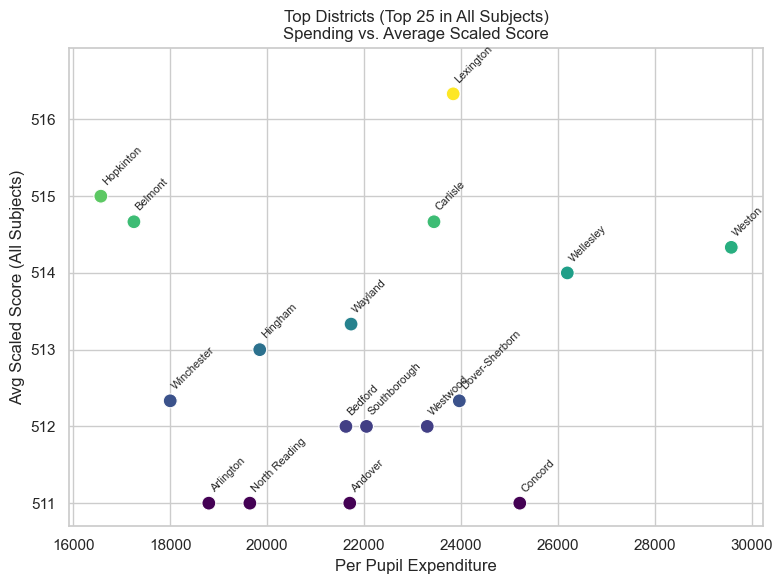

In [377]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_top_all,
    x='per_pupil_expenditure',
    y='avg_score_all_subjects',
    hue='avg_score_all_subjects',
    palette='viridis',
    s=100,
    legend=False
)

# Add rotated labels
for i, row in df_top_all.iterrows():
    plt.text(
        row['per_pupil_expenditure'],
        row['avg_score_all_subjects'] + 0.12,
        row['district_name'],
        fontsize=8,
        rotation=45,
        ha='left',
        va='bottom'
    )

plt.ylim(df_top_all['avg_score_all_subjects'].min() - 0.3,
         df_top_all['avg_score_all_subjects'].max() + 0.6)

plt.title("Top Districts (Top 25 in All Subjects)\nSpending vs. Average Scaled Score")
plt.xlabel("Per Pupil Expenditure")
plt.ylabel("Avg Scaled Score (All Subjects)")
plt.tight_layout()
plt.show()

What It Reveals:

- Lexington and Hopkinton achieve top-tier scores with moderate to low spending (true overperformers)

- Weston and Wellesley spend the most, but only match—not exceed—some lower-spending peers

- Belmont stands out with strong scores and below-median spending

Now, just in case these districts are a bit too expensive for us, let's take a look at the top 50 across all subject areas. 

In [381]:
# Step 1: Find top 50 by scaled score in each subject
top_50_by_subject = {}
for subject in ['ELA', 'MATH', 'SCI']:
    col = f'avg_scaled_score_{subject}'
    top_50 = df_clean[['district_name', col]].sort_values(col, ascending=False).head(50)
    top_50_by_subject[subject] = set(top_50['district_name'])

# Step 2: Find common districts in all three top 50 lists
top_50_all_three = top_50_by_subject['ELA'] & top_50_by_subject['MATH'] & top_50_by_subject['SCI']

# Step 3: Create comparison DataFrame
columns_to_include = [
    'district_name',
    'avg_scaled_score_ELA', 'avg_scaled_score_MATH', 'avg_scaled_score_SCI',
    'per_pupil_expenditure'
]

df_top50_all = df_clean[df_clean['district_name'].isin(top_50_all_three)][columns_to_include].copy()

# Compute average scaled score
df_top50_all['avg_score_all_subjects'] = df_top50_all[
    ['avg_scaled_score_ELA', 'avg_scaled_score_MATH', 'avg_scaled_score_SCI']
].mean(axis=1)

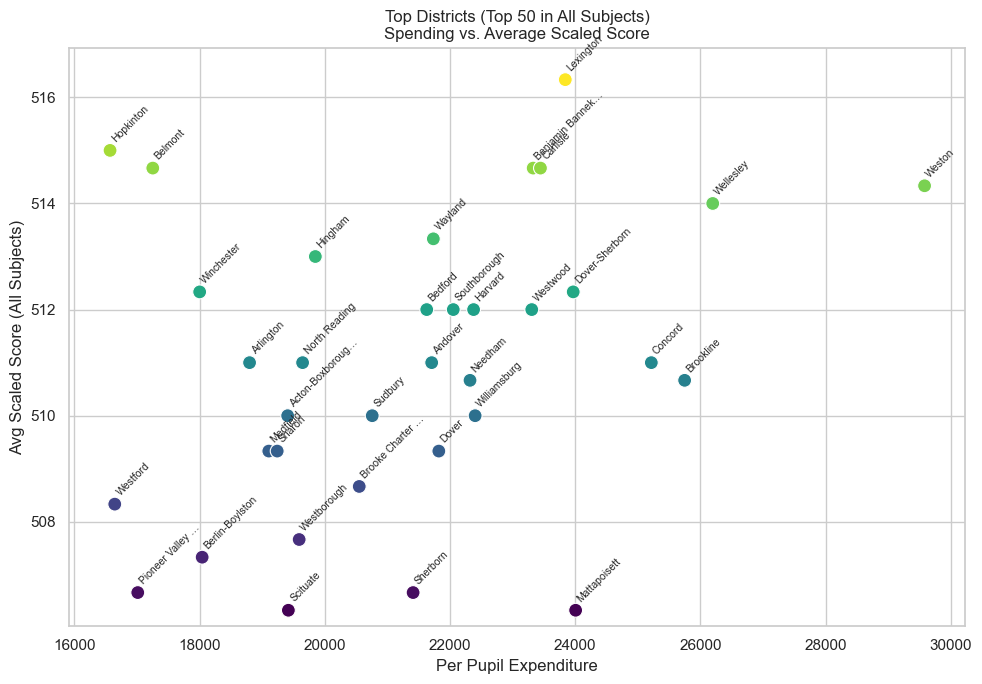

In [383]:
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_top50_all,
    x='per_pupil_expenditure',
    y='avg_score_all_subjects',
    hue='avg_score_all_subjects',
    palette='viridis',
    s=100,
    legend=False
)

# Add truncated and rotated labels
for i, row in df_top50_all.iterrows():
    label = row['district_name'][:15] + "…" if len(row['district_name']) > 15 else row['district_name']
    plt.text(
        row['per_pupil_expenditure'],
        row['avg_score_all_subjects'] + 0.12,
        label,
        fontsize=7.5,
        rotation=45,
        ha='left',
        va='bottom'
    )

plt.ylim(df_top50_all['avg_score_all_subjects'].min() - 0.3,
         df_top50_all['avg_score_all_subjects'].max() + 0.6)

plt.title("Top Districts (Top 50 in All Subjects)\nSpending vs. Average Scaled Score")
plt.xlabel("Per Pupil Expenditure")
plt.ylabel("Avg Scaled Score (All Subjects)")
plt.tight_layout()
plt.show()

Final Summary: District Performance vs. Spending

This analysis identifies Massachusetts districts that consistently rank in the Top 50 across all three subjects—ELA, Math, and Science—based on average scaled scores. We then examine how these high-performing districts compare in terms of per pupil expenditure.

Key Findings:
17 districts were found to rank in the Top 25 for all subjects, and many more appeared in the Top 50.

A color-coded scatterplot shows how average scaled score relates to spending, with district labels rotated and truncated for clarity.

Notably:

- Lexington, Hopkinton, and Belmont stand out with exceptionally high academic performance and moderate to below-average spending.

- Wellesley and Weston are top scorers with high spending, confirming their investment aligns with strong results.

- Several districts achieve similar scaled scores despite very different spending levels, highlighting efficiency vs. investment-driven success.

Interpretation:

This visualization helps reveal which districts are outperforming their investment—a powerful tool for evaluating resource effectiveness in public education. It also surfaces equity considerations, as not all high-scoring districts are high spenders.

While this analysis does not tell us exactly where we should purchase a home, it gives us a good starting point for knowing which districts we may want to focus on. After all, this goes way beyond the 'ratings' and rankings provided in house-hunting websites. It also gives us a good sense, potentially, of the value of a district beyond the particular score rankings we analyzed here: grades 3-8. There are certainly ways we'd want to enrich this data, such as percentage of a home's value that go to property taxes per district; the test scores and percentages of Meets or Exceeds Expectations in higher grades, and more.   